# NYC Taxi Project

## Question 1

#### 1. Programmatically download and load into your favorite analytical tool the trip data for September 2015.
#### 2. Report how many rows and columns of data you have loaded.

We load the green_tripdata_2015-09.csv file from TLC Trip Record Data website. This data sets contains 1494926 rows and 21 columns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(9468)
%matplotlib inline
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
data = pd.read_csv(url, sep=',')
print('The September 2015 NYC green taxi data set has:')
print('{} rows'.format(data.shape[0]))
print('{} columns'.format(data.shape[1]))

The September 2015 NYC green taxi data set has:
1494926 rows
21 columns


## Question 2

#### 1. Plot a histogram of the number of the trip distance (“Trip Distance”).

There are many outliers in trip distance variable. Here is how we handle them in this distribution fitting step:
    1. Extremely large values (as large as 600 miles):          Many are entry errors. Keep values in [Q1-3×IQR, Q3+3×IQR] and use                                                                 fitted distribution to determine exactly IQR later in data cleaning step
    
    2. Zeros:                                                   Some are errors and some are missing values. Exclude them in distribution                                                            fitting step and handle them in data cleaning step


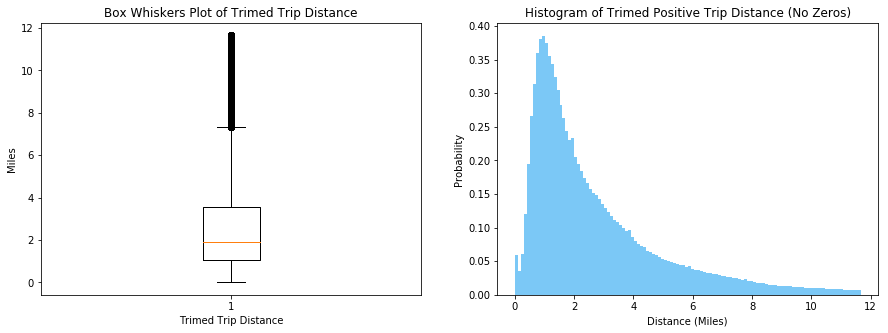

In [2]:
# Roughly handle outliers before fitting distribution
trip_distance = data['Trip_distance']
Q1 = trip_distance.quantile(0.25)
Q3 = trip_distance.quantile(0.75)
IQR = Q3 - Q1
# Using [Q1 - 3 * IQR, Q2 + 3 * IQR] range to keep the right long tail
trip_distance_trimed = trip_distance[(trip_distance > (Q1 - 3 * IQR)) & (trip_distance < (Q3 + 3 * IQR))]
# Keeping even longer tail to create the probability plot
trip_distance_trimed2 = trip_distance[(trip_distance < 100)]
# Box plot of trimed trip distance
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].boxplot(trip_distance_trimed)
axs[0].set_title('Box Whiskers Plot of Trimed Trip Distance')
axs[0].set_xlabel('Trimed Trip Distance')
axs[0].set_ylabel('Miles')
# Histogram of trimed trip distance 
trip_distance_trimed_no_zeros = trip_distance_trimed[trip_distance_trimed > 0]
bins = np.linspace(0, Q3+3*IQR, round((Q3+3*IQR)*10)) # let the bins match the 0.1 mile scale to have a smooth histogram 
x = (bins + (bins[0] + bins[1])/2)[:-1] # use the medians of the bins as ticks for the PDF functions
y, b, patches =  axs[1].hist(trip_distance_trimed_no_zeros, bins, density=True, facecolor='xkcd:lightblue')
axs[1].set_title("Histogram of Trimed Positive Trip Distance (No Zeros)")
axs[1].set_xlabel("Distance (Miles)")
axs[1].set_ylabel("Probability")
plt.show()

Without the extreme  values and zeros, the trip distance variable contains only positive values. The histogram of trip distance is a right skewed distribution with a long right tail. We have several hypotheses of its distribution. It could be Weibull, Inverse Gamma, Log Normal or etc.

#### 2. Report any structure you find and any hypotheses you have about that structure.

We fit the potential distributions to the histogram. Then compare the sum of squared errors (SSE) as well as the probability plots.

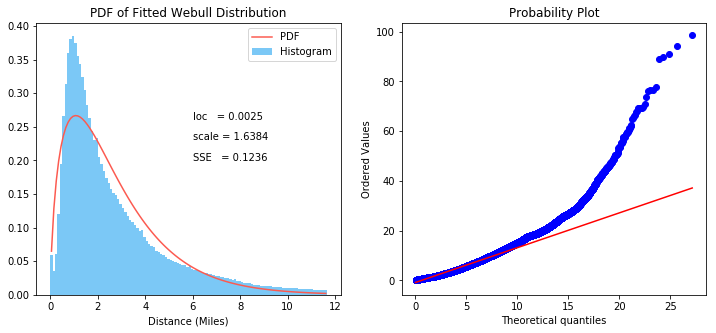

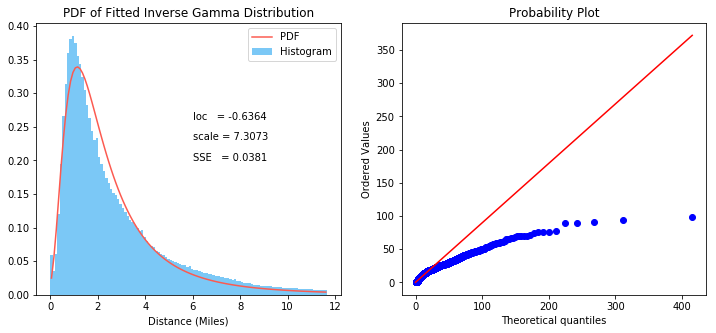

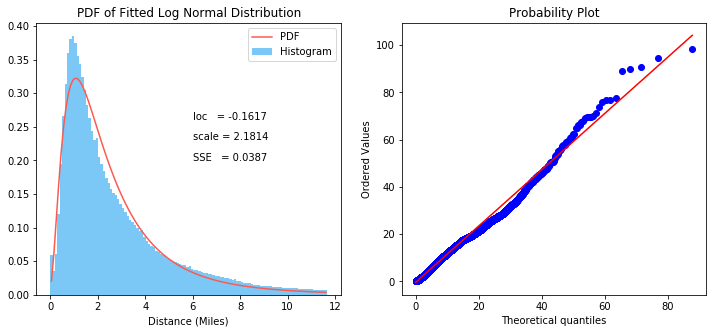

In [3]:
from scipy import stats
from scipy.stats import probplot
import warnings
warnings.filterwarnings("ignore")
# Defining a function to draw distribution fitting figures and compute the fitting SSE
def fit_dist(dist_type, dist_name):
    for i in range(len(dist_type)):
        distribution = dist_type[i]
        # fit distribution to data
        param = distribution.fit(trip_distance_trimed_no_zeros)
        # create pdf curve of the fitted distribution
        pdf = distribution.pdf(x, loc = param[-2], scale = param[-1], *param[:-2])
        # compute SSE
        sse = np.sum(np.power(y - pdf, 2.0))
        # determine the size of figures
        fig, axs = plt.subplots(1, 2, figsize=(12,5))
        axs[0].set_title('PDF of Fitted {} Distribution'.format(dist_name[i]))
        axs[0].set_xlabel("Distance (Miles)")
        axs[0].hist(trip_distance_trimed_no_zeros, bins, density=True, facecolor='xkcd:lightblue', label='Histogram')
        axs[0].plot(x, pdf, 'xkcd:coral', label='PDF')
        axs[0].text(6, 0.2,  "SSE   = {}".format(round(sse,4)))
        axs[0].text(6, 0.23, "scale = {}".format(round(param[-1],4)))
        axs[0].text(6, 0.26, "loc   = {}".format(round(param[-2],4)))
        axs[0].legend()
        probplot(trip_distance_trimed2, dist=distribution, sparams=param, plot=plt)
        plt.show()
# Compare potential distributions
dist_type = [stats.gamma, stats.invgamma, stats.lognorm]
dist_name = ['Webull', 'Inverse Gamma', 'Log Normal']
fit_dist(dist_type, dist_name)

The Inverse Gamma distribution and Log Normal distribution  have the lowest SSEs, but Inverse Gamma has systematical departure from the red line in the probability plot. It is because the Inverse Gamma distribution assumes higher probability for large values (fat tail), but it is not the case in trip distance data. The Log Normal distribution nicely explained the trip distance values, so we conclude that the trip distance variable follows a Log Normal distribution (loc = -0.1617, scale = 2.1814). We will use this distribution to identify the IQR outliers which are close to zero.

## Question 3

#### 1. Report mean and median trip distance grouped by hour of day.

There are two date-time variables: pickup date-time and dropoff date-time. Without loss of generality, we use pickup time to represent the whole trip. In the following sections we will build variables such as trip time (duration) and trip speed to take the time period, between pickup and dropoff, into account.

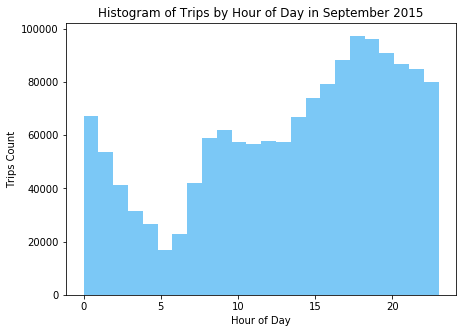

In [4]:
# Creating hour of day variable
pickup_date_time = data['lpep_pickup_datetime'].str.split(" ", n=1, expand=True)
pickup_date = pickup_date_time[0]
pickup_time = pickup_date_time[1]
pickup_hour_min = pickup_time.str.split(":", n=1, expand=True)
hour = pickup_hour_min[0].astype(int)
data['Hour_of_day'] = hour
# Plotting the histogram of hour of day
fig, axs = plt.subplots(1, 1, figsize=(7,5))
axs.hist(hour, 24, facecolor='xkcd:lightblue')
axs.set_title("Histogram of Trips by Hour of Day in September 2015")
axs.set_xlabel("Hour of Day")
axs.set_ylabel("Trips Count")
plt.show()

According the histogram of trip count by hour of day, the rush hours are in the mornings and evenings. The off-peak hours are in early mornings and early afternoons.

Before we move on to study the properties and relationship between the variables, we need to handle the outliners and missing values all over the data set. Here is how we handle them in data cleaning step:
### Data Cleaning
#### Categorical Variables:
    1. VendorID:                  Encode in feature engineering step.
    2. Store and FWD Flag:        Encode in feature engineering step.
    3. RateCodeID:                Encode in feature engineering step.
    4. Payment Type:              Encode in feature engineering step.
    5. Trip Type:                 Encode in feature engineering step.
#### Coordinates:
    1. Pickup Longitude:          Impute zeros.
    2. Dropoff Longitude:         Impute zeros.
    3. Pickup Latitude:           Impute zeros.
    4. Pickup Latitude:           Impute zeros.
#### Date and Time:
    1. Lpep Pickup Datetime:      Extract new features in feature engineering step.
    2. Lpep Dropoff Datetime:     Extract new features in feature engineering step.
#### Discrete Variable:
    1. Passenger Count:           Impute zeros.
#### Continuous Variables:
    1. Trip Distance:             Handle IQR outliers, drop zeros when fees are zeros, impute zeros when fees are non-zeros.
    2. Fare Amount:               Handle IQR outliers, drop negative values.
    3. Extra:                     Handle IQR outliers, drop negative values.
    4. MTA Tax:                   Handle IQR outliers, drop negative values.
    5. Tip Amount:                Handle IQR outliers, drop negative values.
    6. Tolls Amount:              Handle IQR outliers, drop negative values.
    7. Improvement:               Handle IQR outliers, drop negative values.
    8. Total Amount:              Handle IQR outliers, drop negative values and zeros.

For missing data, we can impute them with variable means. But it is not the ideal since the imputed means can bias the distributions. Here we use KNN regressor to conduct HOT DECK imputation. This imputation method can keep most of the information of the missing values.

In [5]:
def data_cleaning(data):
    np.random.seed(4613)
    # The Ehail Fee feature contains no information so we can drop it from data set
    data_preprocess = data.drop(columns = ['Ehail_fee']).copy()
    # The NaNs in Trip Type feature are observations are entry errors. These observations contains little information
    data_preprocess = data_preprocess.drop(np.where(data_preprocess['Trip_type '].isnull())[0], axis=0)
    # Dropping observations with negative fares
    data_preprocess = data_preprocess.loc[((data_preprocess['Fare_amount'] >= 0) & (data_preprocess['Extra'] >= 0) 
                                           & (data_preprocess['MTA_tax'] >= 0) & (data_preprocess['Tip_amount'] >= 0)
                                           & (data_preprocess['Tolls_amount'] >= 0) & (data_preprocess['improvement_surcharge'] >= 0)
                                            & (data_preprocess['Total_amount'] > 0)),:]
    # Dropping observations with both zero trip distance and zero fares
    data_preprocess = data_preprocess.drop(np.where(np.sum(data_preprocess.iloc[:,10:18],axis=1)==0)[0],axis=0)
    # Exclude outliers of trip distance variable given its log normal distribution, but keep the zero trip distances for imputation step
    Q1_log = np.log(data_preprocess['Trip_distance'][data_preprocess['Trip_distance'] > 0]).quantile(0.25)
    Q3_log = np.log(data_preprocess['Trip_distance'][data_preprocess['Trip_distance'] > 0]).quantile(0.75)
    IQR_log = Q3_log - Q1_log
    upper_bound = np.exp(Q3_log + 1.5 * IQR_log)
    lower_bound = np.exp(Q1_log - 1.5 * IQR_log)
    data_preprocess = data_preprocess.loc[(((data_preprocess['Trip_distance'] > lower_bound) & (data_preprocess['Trip_distance'] < upper_bound)) 
                                       ^ (data_preprocess['Trip_distance'] == 0)),:]
    # Imputing the missing values using KNN regressor
    from sklearn.neighbors import KNeighborsRegressor
    # Impute Pickup_longitude
    knn_pickup_longitude = KNeighborsRegressor(n_neighbors = 5, weights = 'distance',  metric = 'minkowski', p = 2, n_jobs = 10)
    knn_pickup_longitude.fit(data_preprocess.loc[data_preprocess['Pickup_longitude'] != 0, ['Pickup_latitude', 'Dropoff_longitude',
                                                                                            'Dropoff_latitude', 'Passenger_count',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']],
                                                data_preprocess.loc[data_preprocess['Pickup_longitude'] != 0, ['Pickup_longitude']])
    data_preprocess.loc[data_preprocess['Pickup_longitude'] == 0, ['Pickup_longitude']] = knn_pickup_longitude.predict(data_preprocess.loc[data_preprocess['Pickup_longitude'] == 0, ['Pickup_latitude', 'Dropoff_longitude',
                                                                                            'Dropoff_latitude', 'Passenger_count',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']])
    # Impute Pickup_latitude
    knn_pickup_latitude = KNeighborsRegressor(n_neighbors = 5, weights = 'distance',  metric = 'minkowski', p = 2, n_jobs = 10)
    knn_pickup_latitude.fit(data_preprocess.loc[data_preprocess['Pickup_latitude'] != 0, ['Pickup_longitude', 'Dropoff_longitude',
                                                                                            'Dropoff_latitude', 'Passenger_count',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']],
                                                data_preprocess.loc[data_preprocess['Pickup_latitude'] != 0, ['Pickup_latitude']])
    data_preprocess.loc[data_preprocess['Pickup_latitude'] == 0, ['Pickup_latitude']] = knn_pickup_latitude.predict(data_preprocess.loc[data_preprocess['Pickup_latitude'] == 0, ['Pickup_longitude', 'Dropoff_longitude',
                                                                                            'Dropoff_latitude', 'Passenger_count',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']])
    # Impute Dropoff_longitude
    knn_dropoff_longitude = KNeighborsRegressor(n_neighbors = 5, weights = 'distance',  metric = 'minkowski', p = 2, n_jobs = 10)
    knn_dropoff_longitude.fit(data_preprocess.loc[data_preprocess['Dropoff_longitude'] != 0, ['Pickup_longitude', 'Pickup_latitude',
                                                                                            'Dropoff_latitude', 'Passenger_count',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']],
                                                data_preprocess.loc[data_preprocess['Dropoff_longitude'] != 0, ['Dropoff_longitude']])
    data_preprocess.loc[data_preprocess['Dropoff_longitude'] == 0, ['Dropoff_longitude']] = knn_dropoff_longitude.predict(data_preprocess.loc[data_preprocess['Dropoff_longitude'] == 0, ['Pickup_longitude', 'Pickup_latitude',
                                                                                            'Dropoff_latitude', 'Passenger_count',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']])
    # Impute Dropoff_latitude
    knn_dropoff_latitude = KNeighborsRegressor(n_neighbors = 5, weights = 'distance',  metric = 'minkowski', p = 2, n_jobs = 10)
    knn_dropoff_latitude.fit(data_preprocess.loc[data_preprocess['Dropoff_latitude'] != 0, ['Pickup_longitude', 'Pickup_latitude',
                                                                                            'Dropoff_longitude', 'Passenger_count',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']],
                                                data_preprocess.loc[data_preprocess['Dropoff_latitude'] != 0, ['Dropoff_latitude']])
    data_preprocess.loc[data_preprocess['Dropoff_latitude'] == 0, ['Dropoff_latitude']] = knn_dropoff_latitude.predict(data_preprocess.loc[data_preprocess['Dropoff_latitude'] == 0, ['Pickup_longitude', 'Pickup_latitude',
                                                                                            'Dropoff_longitude', 'Passenger_count',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']])
    # Impute Passenger_count
    knn_passenger_count = KNeighborsRegressor(n_neighbors = 5, weights = 'distance',  metric = 'minkowski', p = 2, n_jobs = 10)
    knn_passenger_count.fit(data_preprocess.loc[data_preprocess['Passenger_count'] != 0, ['Pickup_longitude', 'Pickup_latitude',
                                                                                            'Dropoff_longitude', 'Dropoff_latitude',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']],
                                                data_preprocess.loc[data_preprocess['Passenger_count'] != 0, ['Passenger_count']])
    data_preprocess.loc[data_preprocess['Passenger_count'] == 0, ['Passenger_count']] = knn_passenger_count.predict(data_preprocess.loc[data_preprocess['Passenger_count'] == 0, ['Pickup_longitude', 'Pickup_latitude',
                                                                                            'Dropoff_longitude', 'Dropoff_latitude',
                                                                                            'Trip_distance', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']])
    # Impute Trip_distance
    knn_trip_distance = KNeighborsRegressor(n_neighbors = 5, weights = 'distance',  metric = 'minkowski', p = 2, n_jobs = 10)
    knn_trip_distance.fit(data_preprocess.loc[data_preprocess['Trip_distance'] != 0, ['Pickup_longitude', 'Pickup_latitude',
                                                                                            'Dropoff_longitude', 'Dropoff_latitude',
                                                                                            'Passenger_count', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']],
                                                    data_preprocess.loc[data_preprocess['Trip_distance'] != 0, ['Trip_distance']])
    data_preprocess.loc[data_preprocess['Trip_distance'] == 0, ['Trip_distance']] = knn_trip_distance.predict(data_preprocess.loc[data_preprocess['Trip_distance'] == 0, ['Pickup_longitude', 'Pickup_latitude',
                                                                                            'Dropoff_longitude', 'Dropoff_latitude',
                                                                                            'Passenger_count', 'Fare_amount', 'Extra',
                                                                                            'MTA_tax', 'Tip_amount', 'Tolls_amount', 
                                                                                            'improvement_surcharge', 'Total_amount']])
    return data_preprocess 

In [6]:
data_preprocessed = data_cleaning(data)

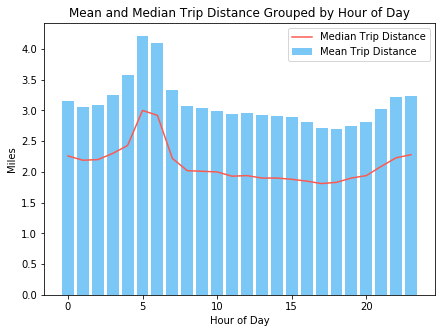

In [7]:
# Plotting the mean and median trip distance by hour of day
mean_distance = data_preprocessed.groupby('Hour_of_day')['Trip_distance'].mean()
median_distance = data_preprocessed.groupby('Hour_of_day')['Trip_distance'].median()
fig, axs = plt.subplots(1, 1, figsize=(7,5))
axs.bar(range(24), mean_distance, facecolor='xkcd:lightblue', label="Mean Trip Distance")
axs.plot(range(24), median_distance, 'xkcd:coral', label="Median Trip Distance")
axs.set_title('Mean and Median Trip Distance Grouped by Hour of Day')
axs.set_xlabel('Hour of Day')
axs.set_ylabel('Miles')
axs.legend()
plt.show()

We can notice two facts from the figure above. First, the mean and median trip distance have the same trend over hour of day, and the mean is larger than the median since the distribution of trip distance is right skewed. Second, the mean/median trip distance reach their maximum at 5:00 and their minimum at 18:00. It is because there are fewer short-distance passengers at 5:00 but the long-distance passengers who want to catch a flight have less flexibility. So the mean/median trip distance is driven up. Similar logic, there are a lot of short-distance passengers at 18:00 to travel from work to home or restaurant. So, the mean/median trip distance is driven down.

#### 2. We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.

We could use RateCodeID variable to have a rough idea of the trips originate or terminate at JFK Airport and Newark Airport. But according to the trip plot, those codes are usually not accurate. Many trips that originate or terminate at airports didn't use the airport codes and many others that used airport codes never went to the airports. Another reason we are not using the RateCodeID is that it doesn't indicate the trips originate or terminate at LaGuardia Airport. Therefore, we use coordinates to locate the trips.

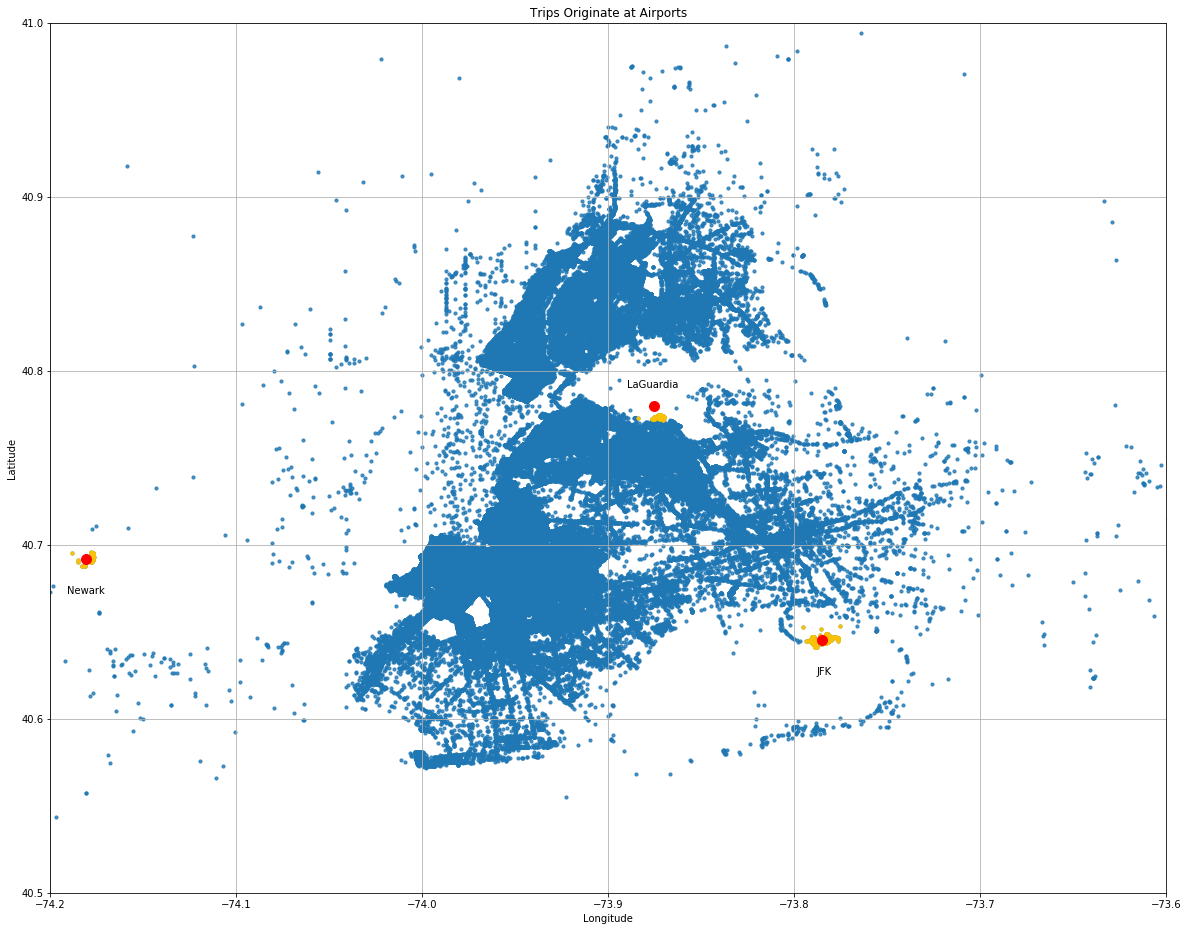

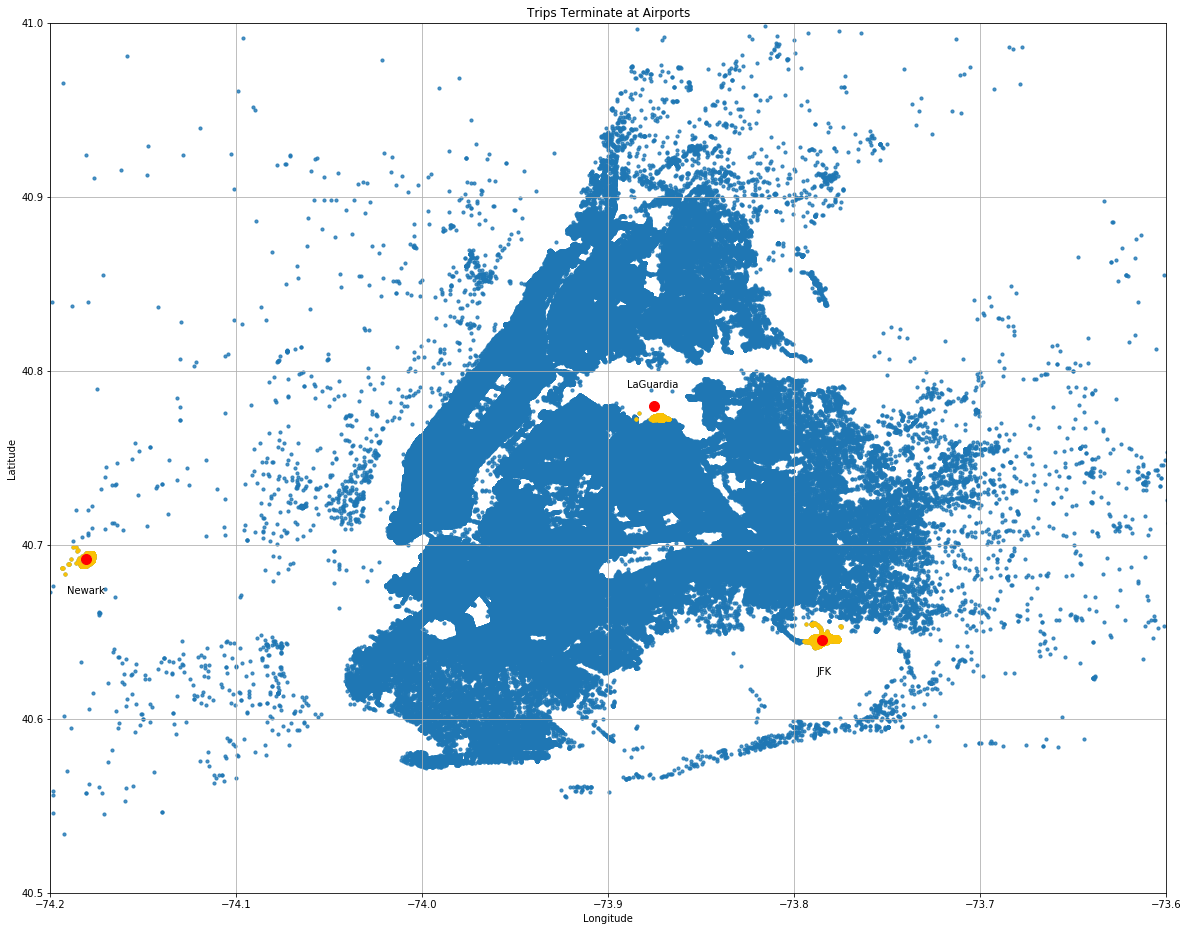

Number of trips originate or terminate at one of the NYC area airports: 24429
Average fare of these airport trips: $31.87


In [8]:
# Identifying the trips originate or terminate at one of the NYC area airports
pickup_at_airport = (((data_preprocessed['Pickup_longitude'] < -73.7701) & (data_preprocessed['Pickup_longitude'] > -73.7951)
                   &(data_preprocessed['Pickup_latitude'] < 40.6553) & (data_preprocessed['Pickup_latitude'] > 40.6353))
                   ^((data_preprocessed['Pickup_longitude'] < -73.8652) & (data_preprocessed['Pickup_longitude'] > -73.8852)
                   &(data_preprocessed['Pickup_latitude'] < 40.7850) & (data_preprocessed['Pickup_latitude'] > 40.7720))
                   ^((data_preprocessed['Pickup_longitude'] < -74.1608) & (data_preprocessed['Pickup_longitude'] > -74.2008)
                   &(data_preprocessed['Pickup_latitude'] < 40.7016) & (data_preprocessed['Pickup_latitude'] > 40.6816)))
dropoff_at_airport = (((data_preprocessed['Dropoff_longitude'] < -73.7701) & (data_preprocessed['Dropoff_longitude'] > -73.7951)
                   &(data_preprocessed['Dropoff_latitude'] < 40.6553) & (data_preprocessed['Dropoff_latitude'] > 40.6353))
                   ^((data_preprocessed['Dropoff_longitude'] < -73.8652) & (data_preprocessed['Dropoff_longitude'] > -73.8852)
                   &(data_preprocessed['Dropoff_latitude'] < 40.7850) & (data_preprocessed['Dropoff_latitude'] > 40.7720))
                   ^((data_preprocessed['Dropoff_longitude'] < -74.1608) & (data_preprocessed['Dropoff_longitude'] > -74.2008)
                   &(data_preprocessed['Dropoff_latitude'] < 40.7016) & (data_preprocessed['Dropoff_latitude'] > 40.6816)))
# Plotting the trips originate at airports
fig, axs = plt.subplots(figsize=(20,16))
plt.scatter(data_preprocessed['Pickup_longitude'],data_preprocessed['Pickup_latitude'], s=10, alpha=0.8)
plt.scatter(data_preprocessed.loc[pickup_at_airport,['Pickup_longitude']],data_preprocessed.loc[pickup_at_airport,['Pickup_latitude']],s=10,c='xkcd:goldenrod')
plt.scatter(-73.7851391, 40.6453111, s=100, c='r')
plt.scatter(-74.1807659156, 40.6916321895, s=100, c='r')
plt.scatter(-73.8752298524, 40.7800135746, s=100, c='r')
plt.text(-73.7881, 40.6253, "JFK")
plt.text(-73.8902, 40.7900, "LaGuardia")
plt.text(-74.1908, 40.6716, "Newark")
plt.ylim(40.5,41)
plt.xlim(-74.2,-73.6)
plt.title('Trips Originate at Airports')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()
# Plotting the trips terminate at airports
fig, axs = plt.subplots(figsize=(20,16))
plt.scatter(data_preprocessed['Dropoff_longitude'],data_preprocessed['Dropoff_latitude'], s=10, alpha=0.8)
plt.scatter(data_preprocessed.loc[dropoff_at_airport,['Dropoff_longitude']],data_preprocessed.loc[dropoff_at_airport,['Dropoff_latitude']],s=10,c='xkcd:goldenrod')
plt.scatter(-73.7851391, 40.6453111, s=100, c='r')
plt.scatter(-74.1807659156, 40.6916321895, s=100, c='r')
plt.scatter(-73.8752298524, 40.7800135746, s=100, c='r')
plt.text(-73.7881, 40.6253, "JFK")
plt.text(-73.8902, 40.7900, "LaGuardia")
plt.text(-74.1908, 40.6716, "Newark")
plt.ylim(40.5,41)
plt.xlim(-74.2,-73.6)
plt.title('Trips Terminate at Airports')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()
# Identifying airport trips
trip_airport = pickup_at_airport ^ dropoff_at_airport
data_preprocessed['Trip_airport'] = trip_airport.astype(int)
print('Number of trips originate or terminate at one of the NYC area airports: {}'.format(np.where(trip_airport)[0].shape[0]))
print('Average fare of these airport trips: ${}'.format(np.round(data_preprocessed.Fare_amount[trip_airport].mean(),2)))

In the coordinate’s plots, the red dots are the location of the three main airports in New York. The yellow dots are trips either originated or terminated at these three airports. We mark an Airport trip if it originated or terminated or both at the airports. There are 24429 trips from or to the airports, which is 1.65% of the total trips. The average fare of these airport trips is 31.87 dollars. It is much higher than the average fare of all trips, 12.55 dollars, since two of the airports, JFK and Newark, are far from the downtown area. Let's compare some characteristics of the airport and non-airport groups.

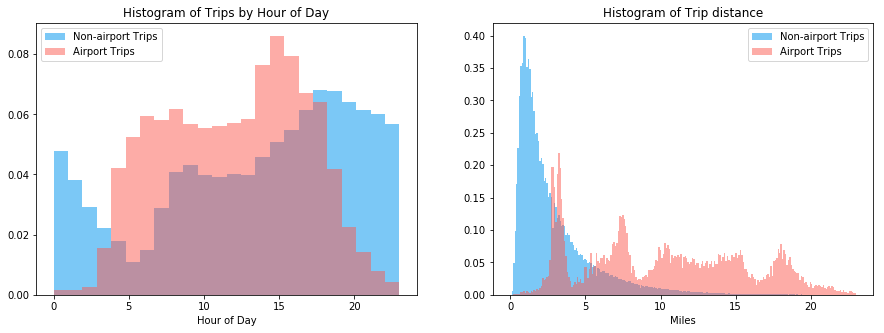

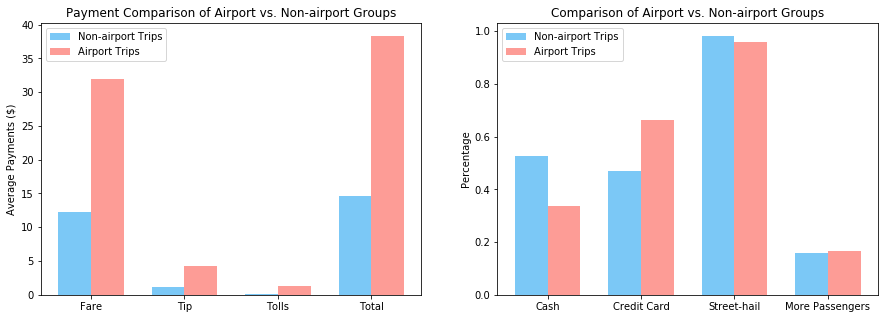

In [9]:
# Plotting histogrames of hour of day for airport & non-airport groups
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(data_preprocessed.Hour_of_day[-trip_airport],24,facecolor='xkcd:lightblue', density=True, label='Non-airport Trips')
axs[0].hist(data_preprocessed.Hour_of_day[trip_airport],24,facecolor='xkcd:coral', alpha=0.5, density=True, label='Airport Trips')
axs[0].set_title("Histogram of Trips by Hour of Day")
axs[0].set_xlabel("Hour of Day")
axs[0].legend()
# Plotting histograms of trip distance for airport & non-airport groups
bins = np.linspace(0, int(23.91), int((23.91)*10))
axs[1].hist(data_preprocessed.Trip_distance[-trip_airport],bins,facecolor='xkcd:lightblue', density=True, label='Non-airport Trips')
axs[1].hist(data_preprocessed.Trip_distance[trip_airport],bins,facecolor='xkcd:coral', alpha=0.5, density=True, label='Airport Trips')
axs[1].set_title("Histogram of Trip distance")
axs[1].set_xlabel("Miles")
axs[1].legend()
plt.show()
# Compare fare difference between airport & non-airport groups
n_features = 4
features_mean_airport = (data_preprocessed.Fare_amount[trip_airport].mean(), data_preprocessed.Tip_amount[trip_airport].mean(), data_preprocessed.Tolls_amount[trip_airport].mean(),data_preprocessed.Total_amount[trip_airport].mean())
features_mean_nonairport = (data_preprocessed.Fare_amount[-trip_airport].mean(), data_preprocessed.Tip_amount[-trip_airport].mean(), data_preprocessed.Tolls_amount[-trip_airport].mean(),data_preprocessed.Total_amount[-trip_airport].mean())
fig, axs = plt.subplots(1, 2, figsize=(15,5))
index = np.arange(n_features)
bar_width = 0.35
axs[0].bar(index, features_mean_nonairport, bar_width, color='xkcd:lightblue', label='Non-airport Trips')
axs[0].bar(index + bar_width, features_mean_airport, bar_width, alpha=0.6, color='xkcd:coral', label='Airport Trips')
axs[0].set_ylabel('Average Payments ($)')
axs[0].set_title('Payment Comparison of Airport vs. Non-airport Groups')
axs[0].set_xticks(index + bar_width/2)
axs[0].set_xticklabels(['Fare', 'Tip', 'Tolls', 'Total'])
axs[0].legend()
# Compare other features between airport & non-airport groups
features_mean_airport    = (((data_preprocessed.Payment_type[trip_airport] == 2).astype(int).sum())/((trip_airport == 1).astype(int).sum()),
                            ((data_preprocessed.Payment_type[trip_airport] == 1).astype(int).sum())/((trip_airport == 1).astype(int).sum()),
                            ((data_preprocessed.loc[trip_airport,['Trip_type ']] == 1).astype(int).sum())/((trip_airport == 1).astype(int).sum()),
                            ((data_preprocessed.Passenger_count[trip_airport] > 1).astype(int).sum())/((trip_airport == 1).astype(int).sum()))
features_mean_nonairport = (((data_preprocessed.Payment_type[-trip_airport] == 2).astype(int).sum())/((trip_airport == 0).astype(int).sum()),
                            ((data_preprocessed.Payment_type[-trip_airport] == 1).astype(int).sum())/((trip_airport == 0).astype(int).sum()),
                            ((data_preprocessed.loc[-trip_airport,['Trip_type ']] == 1).astype(int).sum())/((trip_airport == 0).astype(int).sum()),
                            ((data_preprocessed.Passenger_count[-trip_airport] > 1).astype(int).sum())/((trip_airport == 0).astype(int).sum()))
index = np.arange(n_features)
axs[1].bar(index, features_mean_nonairport, bar_width, color='xkcd:lightblue', label='Non-airport Trips')
axs[1].bar(index + bar_width, features_mean_airport, bar_width, alpha=0.6, color='xkcd:coral', label='Airport Trips')
axs[1].set_ylabel('Percentage')
axs[1].set_title('Comparison of Airport vs. Non-airport Groups')
axs[1].set_xticks(index + bar_width/2)
axs[1].set_xticklabels(['Cash', 'Credit Card', 'Street-hail', 'More Passengers'])
axs[1].legend()
plt.show()

Most airport trips are in the 4:00-20:00 period and there is a peak at 15:00. Thanks to airline companies' pricing strategies, flight passengers are very happy to accept the low rates in off peak hours and the airline capacity is sufficiently utilized, which means the flow of taxi passenger to the airports is pretty constant outside the night hours. The airport trips tend to have higher distance and a pretty flat distribution of it. The spike near 4 miles may be the trips of LaGuardia Airport. In addition to trip count and distance, the airport trips tend to raise higher fare, tip and fees. The passengers of airport trips are more willing to use credit card than use cash to pay their trips.

## Question 4

#### 1. Build a derived variable for tip as a percentage of the total fare.

Our target is to predict tip as a percentage of the total fare. First let's have a look at the distribution of tip_percent.

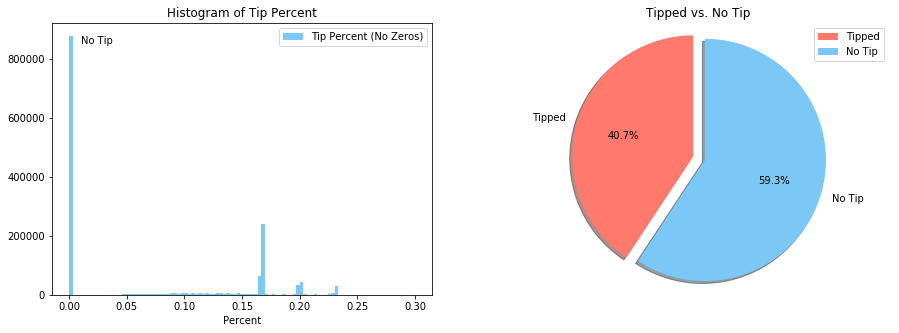

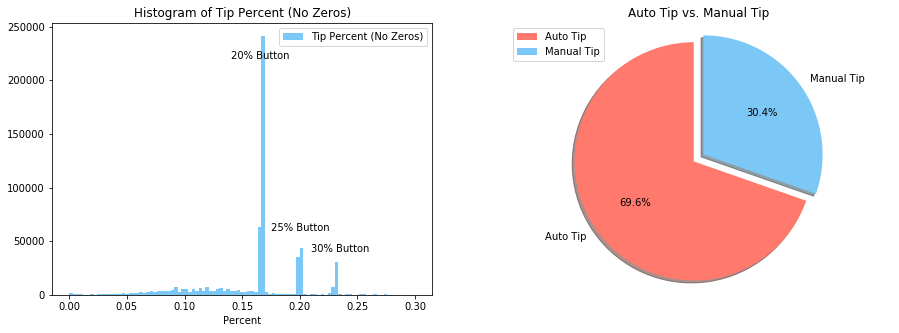

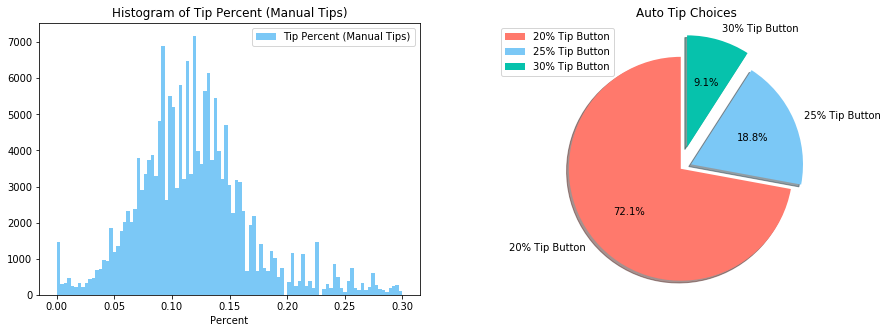

In [10]:
# Creating tip percent，tipped and auto tip features
tip_percent  = data_preprocessed.Tip_amount / data_preprocessed.Total_amount
tipped = (tip_percent > 0).astype(int)
auto_tip = (((tip_percent > 0.1650) & (tip_percent < 0.1668))                 # 20%  button
            ^ ((tip_percent > 0.1950) & (tip_percent < 0.20075))              # 25% button
            ^ ((tip_percent > 0.2270) & (tip_percent < 0.2310))).astype(int)  # 30% button
data_preprocessed['Tip_percent'] = tip_percent
data_preprocessed['Tipped'] = tipped
data_preprocessed['Auto_tip'] = auto_tip
data_preprocessed['Tip_button'] = 0
data_preprocessed.loc[(tip_percent > 0.1950) & (tip_percent < 0.20075),['Tip_button']] = 1
data_preprocessed.loc[(tip_percent > 0.2270) & (tip_percent < 0.2310),['Tip_button']]  = 2
# Plotting a histogram of all tip percent
fig, axs = plt.subplots(1, 2, figsize=(15,5))
bins = np.linspace(0, 0.3, 100)
axs[0].hist(data_preprocessed.Tip_percent, bins, facecolor='xkcd:lightblue', label='Tip Percent (No Zeros)')
axs[0].text(0.01, 850000, "No Tip")
axs[0].set_title("Histogram of Tip Percent")
axs[0].set_xlabel("Percent")
axs[0].legend()
# Plotting a pie to compare tipped and no tip groups
axs[1].pie([((data_preprocessed['Tipped']==1).astype(int).sum())*100/data_preprocessed.shape[0], 
            ((data_preprocessed['Tipped']==0).astype(int).sum())*100/data_preprocessed.shape[0]], 
           explode=[0, 0.1], labels=['Tipped','No Tip'], colors = ['xkcd:salmon', 'xkcd:lightblue'],
           autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].set_title("Tipped vs. No Tip")
axs[1].legend()
plt.show()
# Plotting the histogram of non-zero tip percent
fig, axs = plt.subplots(1, 2, figsize=(15,5))
bins = np.linspace(0, 0.3, 100)
axs[0].hist(data_preprocessed.Tip_percent[tip_percent > 0], bins, facecolor='xkcd:lightblue', label='Tip Percent (No Zeros)')
axs[0].text(0.14, 220000, "20% Button")
axs[0].text(0.175, 60000,  "25% Button")
axs[0].text(0.21, 40000,  "30% Button")
axs[0].set_title("Histogram of Tip Percent (No Zeros)")
axs[0].set_xlabel("Percent")
axs[0].legend()
# Plotting a pie to compare the manually entered tip and automatic tip groups given that there is a tip
axs[1].pie([(auto_tip.sum())*100/tipped.sum(), 
            (tipped.sum()-auto_tip.sum())*100/tipped.sum()], 
           explode=[0, 0.1], labels=['Auto Tip','Manual Tip'], colors = ['xkcd:salmon', 'xkcd:lightblue'],
           autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].set_title("Auto Tip vs. Manual Tip")
axs[1].legend()
plt.show()
# Plotting the histogram of tip percent entered manually
fig, axs = plt.subplots(1, 2, figsize=(15,5))
bins = np.linspace(0, 0.3, 100)
axs[0].hist(data_preprocessed.Tip_percent[(tip_percent > 0) & (auto_tip ==0)], bins, facecolor='xkcd:lightblue', label='Tip Percent (Manual Tips)')
axs[0].set_title("Histogram of Tip Percent (Manual Tips)")
axs[0].set_xlabel("Percent")
axs[0].legend()
# Plotting a pie to compare the automatic tip choices
axs[1].pie([(auto_tip.sum()-(data_preprocessed['Tip_button']>0).astype(int).sum())*100/auto_tip.sum(), 
            ((data_preprocessed['Tip_button']==1).astype(int).sum())*100/auto_tip.sum(),
           ((data_preprocessed['Tip_button']==2).astype(int).sum())*100/auto_tip.sum()], 
           explode=[0, 0.1, 0.2], labels=['20% Tip Button', '25% Tip Button', '30% Tip Button'], colors = ['xkcd:salmon', 'xkcd:lightblue', 'xkcd:turquoise'],
           autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].set_title("Auto Tip Choices")
axs[1].legend()
plt.show()

From the histogram of all tip percentage values at upper left, we can hardly see the details except the spikes. The highest spike stands for zero tip percentages. There are 59.3% trips with no tip. It might be the case that the passenger didn't tip, or it was cash tip. The middle left histogram shows that except the zero tip percentages, there are three more spikes. These spikes stand for 20%, 25%, 30% tip percentage respectively. These values are important since they are automatic tip choices on the payment monitor. There are 69.6% passengers hit the automatic tip buttons. Among them, 72.1% passengers chose the 20% button, 18.8% chose the 25% button and the others chose 30% button. With these spikes, it is difficult for a regression model to predict the tip percentage well since the model will focus on the spikes and overlook the details between them. if we exclude the spikes from the histogram, the remaining tip percentages have a log-normal like distribution, which is much easier for regression models to handle. 

To have a better prediction of tip percentages, instead of building one regression model, we build four models and combine them to a complex model. These models are:
###  <font color='blue'>Model 1</font>  (Classification Model): Predict if there will be a  <font color='red'>tip</font>  or  <font color='red'>not</font> 

###  <font color='blue'>Model 2</font>  (Classification Model): If model 1 predicts a tip, predict the passenger uses an  <font color='red'>automatic tip</font>  button or enters the tip  <font color='red'>manually</font> 

###   <font color='blue'>Model 2.1</font>  (Multi-Class Classification Model): If model 2 predicts an automatic tip, predict which  <font color='red'>tip button</font>  (20%, 25%, 30%) the passenger will choose
###   <font color='blue'>Model 2.2</font>  (Regression Model):  If model 2 predicts a manual tip, predict the  <font color='red'>tip percentage</font> 

Before building the models, it is very important to do feature engineering carefully. Here is how we engineer the features:
### Feature Engineering
#### Feature Extraction:
    1. VendorID:                  Encode one dummy variable.
    2. Store and FWD Flag:        Encode one dummy variable.
    3. RateCodeID:                Encode five dummy variables.
    4. Payment Type:              Encode four dummy variables.
    5. Trip Type:                 Encode one dummy variable.
#### Feature Construction:
    1. Weekday / Weekend:         Dummy variable equals one if it is Saturday or Sunday
    2. High Demand Period:        Dummy variable equals one if it is in 6:00-10:00 and 17:00-2:00 periods
    3. Rush Hours:                Dummy variable equals one if Extra fee equals 0.5 dollar
    4. Over Night:                Dummy variable equals one if Extra fee equals 1.0 dollar
    5. More than one passenger:   Dummy variable equals one if passenger count is larger than one
    6. Trip Time:                 Continuous variable which records the trip duration
    7. Trip Speed:                Continuous variable which records (trip distance / trip time)
    8. Trip High Speed:           Dummy variable equals one if trip speed is larger than 20 mph
    9. Trip Rush Hour High Speed: Dummy variable equals one if both Rush Hours and Trip High Speed equal one
    10.Trip Off Peak Low Speed:   Dummy variable equals one if both Rush Hours and Trip High Speed equal zero
    11.Manhatton Trips:           Dummy variable equals one if the trip pickup or dropoff at Manhattan
#### Constructed Features:
    1. Airport Trip
    2. Hour of day
#### Feature Selection:
We use two feature importance measurements: 1. correlation; 2. random forest feature importance. After deciding importance threshold, each importance measurement gives us a list of features. In data engineering step we combine these two lists to obtain a long list of features. We will conduct further feature elimination in the model testing process.

In [11]:
def data_engineering(data_preprocessed):
    np.random.seed(2486) # 2486
    # Feature extraction: Encode the categorical data
    data_encode = data_preprocessed.drop(columns = ['lpep_pickup_datetime', 'Lpep_dropoff_datetime']).copy()
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    np.random.seed(20180218)
    colT = ColumnTransformer(
        [("dummy_col", OneHotEncoder(categories=[[1, 2],
                                                ['Y', 'N'],
                                                [1, 2, 3, 4, 5, 6],
                                                [1, 2, 3, 4, 5],
                                                [1, 2]]), [0,1,2,16,17])])
    data_encode = pd.DataFrame(colT.fit_transform(data_encode).toarray())
    
    # Feature construction
    ## weekday / weekend
    pickup_y_m_d = data_preprocessed.lpep_pickup_datetime.str.split("-", n=2, expand=True)
    pickup_day_time = pickup_y_m_d[2].str.split(" ", n=1, expand=True)
    pickup_day = pickup_day_time[0].astype(int)
    trip_week = np.ceil((pickup_day + 1) / 7).astype(int)
    pickup_day_of_week = pickup_day % 7 + 1
    trip_weekends = (pickup_day_of_week > 5).astype(int)
    ## High demand period
    high_demand = [0,1,2,6,7,8,9,10,17,18,19,20,21,22,23]
    trip_highdemand = data_preprocessed.Hour_of_day.isin(high_demand).astype(int)
    ## Rush hours
    trip_rushhours = (data_preprocessed.Extra == 0.5).astype(int)
    ## Over night
    trip_overnight = (data_preprocessed.Extra == 1).astype(int)
    ## More than one passenger
    trip_multipassengers = (data_preprocessed.Passenger_count > 1).astype(int)
    ## Trip time
    pickup_date_time = data_preprocessed.lpep_pickup_datetime.str.split(" ", n=1, expand=True)
    pickup_date = pickup_date_time[0]
    pickup_time = pickup_date_time[1]
    pickup_hour_min_sec = pickup_time.str.split(":", n=2, expand=True)
    pickup_hour = pickup_hour_min_sec[0].astype(int)
    pickup_min  = pickup_hour_min_sec[1].astype(int)
    pickup_sec  = pickup_hour_min_sec[2].astype(int)
    pickup_time_in_hour = pickup_day * 24 + pickup_hour + pickup_min/60 + pickup_sec/3600
    dropoff_date_time = data_preprocessed.Lpep_dropoff_datetime.str.split(" ", n=1, expand=True)
    dropoff_date = dropoff_date_time[0]
    dropoff_time = dropoff_date_time[1]
    dropoff_y_m_d= dropoff_date.str.split("-", n=2, expand=True)
    dropoff_day  = dropoff_y_m_d[2].astype(int)
    dropoff_hour_min_sec = dropoff_time.str.split(":", n=2, expand=True)
    dropoff_hour = dropoff_hour_min_sec[0].astype(int)
    dropoff_min  = dropoff_hour_min_sec[1].astype(int)
    dropoff_sec  = dropoff_hour_min_sec[2].astype(int)
    dropoff_time_in_hour = dropoff_day * 24 + dropoff_hour + dropoff_min/60 + dropoff_sec/3600
    trip_time = dropoff_time_in_hour - pickup_time_in_hour
    ## trip speed
    trip_speed = data_preprocessed.Trip_distance / trip_time
    ## trip high speed
    trip_highspeed = (trip_speed > 20).astype(int)
    ## trip rush hour high speed
    trip_rushhours_highspeed = ((trip_rushhours == 1) & (trip_highspeed == 1)).astype(int)
    ## trip non rush hour low speed
    trip_nonrushhours_lowspeed = ((trip_rushhours == 0) & (trip_highspeed == 0)).astype(int)
    ## Manhattan trips
    from numpy.linalg import norm
    point1 = np.array([-74.015, 40.705])
    point2 = np.array([-73.945, 40.81])
    point3 = np.array([-73.99, 40.77])
    point4 = np.array([-73.96, 40.75])
    width1 = 0.0208
    width2 = 0.068
    strip1_pickup = abs(np.cross(point2-point1,data_preprocessed.loc[:,['Pickup_longitude','Pickup_latitude']]-point1)/norm(point2-point1))
    strip2_pickup = abs(np.cross(point4-point3,data_preprocessed.loc[:,['Pickup_longitude','Pickup_latitude']]-point3)/norm(point4-point3))
    pickup_at_manhattan = (strip1_pickup < width1) & (strip2_pickup < width2)
    strip1_dropoff = abs(np.cross(point2-point1,data_preprocessed.loc[:,['Dropoff_longitude','Dropoff_latitude']]-point1)/norm(point2-point1))
    strip2_dropoff = abs(np.cross(point4-point3,data_preprocessed.loc[:,['Dropoff_longitude','Dropoff_latitude']]-point3)/norm(point4-point3))
    dropoff_at_manhattan = (strip1_dropoff < width1) & (strip2_dropoff < width2)
    trip_manhattan = pd.DataFrame((pickup_at_manhattan ^ dropoff_at_manhattan),index = data_preprocessed.index.copy()).astype(int)
    
    # Feature Concat
    categorical_features = data_encode.iloc[:,[0,2,4,5,6,7,8,10,11,12,13,15]].copy() # drop 5 features to avoid dummy variable trap
    categorical_features.index = data_preprocessed.index.copy()
    categorical_features.columns = ['VendorID_1','Store_and_fwd_flag_Y','RateCodeID_1','RateCodeID_2','RateCodeID_3',
                                    'RateCodeID_4','RateCodeID_5','Payment_type_1','Payment_type_2','Payment_type_3',
                                    'Payment_type_4','Trip_type_1']
    constructed_features = pd.concat([trip_highspeed,trip_manhattan,trip_multipassengers,trip_nonrushhours_lowspeed,
                                         trip_rushhours,trip_rushhours_highspeed,trip_speed,trip_time,trip_weekends],axis=1)
    constructed_features.index = data_preprocessed.index.copy()
    constructed_features.columns = ['Trip_highspeed','Trip_manhattan','Trip_multipassengers','Trip_nonrushhours_lowspeed',
                                         'Trip_rushhours','Trip_rushhours_highspeed','Trip_speed','Trip_time','Trip_weekends']
    data_engineering = pd.concat([data_preprocessed.loc[:,['Passenger_count','Trip_distance','Fare_amount','MTA_tax',
                                                           'Tip_amount','Tolls_amount','improvement_surcharge','Total_amount',
                                                           'Hour_of_day','Trip_airport','Tip_percent','Tipped','Auto_tip','Tip_button']],
                                                          categorical_features,constructed_features],axis = 1)
    data_engineering = data_engineering.loc[data_engineering.Trip_speed < 200,:] # Remove trip speed outliers
    data = data_engineering.copy()
    data['Trip_week'] = trip_week
    data['Pickup_day'] = pickup_day
    # Putting aside a test data set for full model
    data_engineering = data_engineering.iloc[np.random.choice(data_engineering.shape[0], data_engineering.shape[0], replace = False),:]
    data_test_full_model = data_engineering.iloc[range(120000),:].copy()
    data_test_full_model['Trip_distance'] = np.log(data_test_full_model['Trip_distance'])
    data_engineering = data_engineering.iloc[120000:data_engineering.shape[0],:]
    
    # Feature Selection
    ## Model 1: predict if there is a tip
    data_temp1 = data_engineering.drop(columns = ['Tip_amount', 'Tip_percent', 'Auto_tip', 'Tip_button']).copy()
    data_model1 = data_temp1.copy()
    ### Correlation
    model1_correlations = data_temp1.corr()
    model1_selected_features_correlation = model1_correlations.columns[np.where(abs(model1_correlations.loc[:,['Tipped']])>0.08)[0]]
    ### Random Forest feature importance
    from sklearn.ensemble import RandomForestClassifier
    model1_selection = RandomForestClassifier(random_state = 3122)
    model1_selection.fit(data_temp1.drop(columns = ['Tipped']), data_temp1['Tipped'])
    model1_selected_features_RF_importances = data_temp1.drop(columns = ['Tipped']).columns[np.where(model1_selection.feature_importances_>0.01)[0]]
    ### Model 1 selected features
    model1_selected_features = list(set().union(model1_selected_features_correlation.difference(['Tipped']),model1_selected_features_RF_importances))
    print('Model 1 target: Tipped')
    print('Model 1 selected features:')
    print(model1_selected_features)
    print(' ')
    data_model1['Trip_distance'] = np.log(data_model1['Trip_distance'])  # transform trip distance to normal distribution
    
    ## Model 2: predict if there is a tip, will the passenger hit the auto tip button or not
    data_engineering_tipped = data_engineering.loc[data_engineering.Tipped == 1,:].copy()
    data_temp2 = data_engineering_tipped.drop(columns = ['Tipped','Tip_amount', 'Tip_percent', 'Tip_button']).copy()
    data_model2 = data_temp2.copy()
    ### Correlation
    model2_correlations = data_temp2.corr()
    model2_selected_features_correlation = model2_correlations.columns[np.where(abs(model2_correlations.loc[:,['Auto_tip']])>0.05)[0]]
    ### Random Forest feature importance
    model2_selection = RandomForestClassifier(random_state = 3123)
    model2_selection.fit(data_temp2.drop(columns = ['Auto_tip']), data_temp2['Auto_tip'])
    model2_selected_features_RF_importances = data_temp2.drop(columns = ['Auto_tip']).columns[np.where(model2_selection.feature_importances_>0.01)[0]]
    ### Model 2 selected features
    model2_selected_features = list(set().union(model2_selected_features_correlation.difference(['Auto_tip']),model2_selected_features_RF_importances))
    print('Model 2 target: Auto_tip')
    print('Model 2 selected features:')
    print(model2_selected_features)
    print(' ')
    data_model2['Trip_distance'] = np.log(data_model2['Trip_distance'])  # transform trip distance to normal distribution
    
    ## Model 3: if is auto tip, predict which button will be hit (20%, 25%, 30%)
    data_engineering_autotip = data_engineering_tipped.loc[data_engineering_tipped.Auto_tip == 1,:].copy()
    data_temp3 = data_engineering_autotip.drop(columns = ['Tipped', 'Tip_amount', 'Tip_percent', 'Auto_tip']).copy()
    data_model3 = data_temp3.copy()
    ### Correlation
    model3_correlations = data_temp3.corr()
    model3_selected_features_correlation = model3_correlations.columns[np.where(abs(model3_correlations.loc[:,['Tip_button']])>0.03)[0]]
    ### Random Forest feature importance
    model3_selection = RandomForestClassifier(random_state = 3124)
    model3_selection.fit(data_temp3.drop(columns = ['Tip_button']), data_temp3['Tip_button'])
    model3_selected_features_RF_importances = data_temp3.drop(columns = ['Tip_button']).columns[np.where(model3_selection.feature_importances_>0.01)[0]]
    ### Model 2 selected features
    model3_selected_features = list(set().union(model3_selected_features_correlation.difference(['Tip_button']),model3_selected_features_RF_importances))
    print('Model 3 target: Tip_button')
    print('Model 3 selected features:')
    print(model3_selected_features)
    print(' ')
    data_model3['Trip_distance'] = np.log(data_model3['Trip_distance'])  # transform trip distance to normal distribution
    
    ## Model 4: if is manual tip, predict tip percent
    data_engineering_tipped = data_engineering.loc[data_engineering.Tipped == 1,:].copy()
    data_engineering_manualtip = data_engineering_tipped.loc[data_engineering_tipped.Auto_tip == 0,:].copy()
    data_temp4 = data_engineering_manualtip.drop(columns = ['Tipped', 'Tip_amount', 'Auto_tip', 'Tip_button']).copy()
    data_model4 = data_temp4.copy()
    ### Correlation
    model4_correlations = data_temp4.corr()
    model4_selected_features_correlation = model4_correlations.columns[np.where(abs(model4_correlations.loc[:,['Tip_percent']])>0.05)[0]]
    ### Random Forest feature importance
    from sklearn.ensemble import RandomForestRegressor
    model4_selection = RandomForestRegressor(random_state = 3125)
    model4_selection.fit(data_temp4.drop(columns = ['Tip_percent']), data_temp4['Tip_percent'])
    model4_selected_features_RF_importances = data_temp4.drop(columns = ['Tip_percent']).columns[np.where(model4_selection.feature_importances_>0.001)[0]]
    ### Model 2 selected features
    model4_selected_features = list(set().union(model4_selected_features_correlation.difference(['Tip_percent']),model4_selected_features_RF_importances))
    print('Model 4 target: Tip_percent')
    print('Model 4 selected features:')
    print(model4_selected_features)
    data_model4['Trip_distance'] = np.log(data_model4['Trip_distance'])  # transform trip distance to normal distribution
    
    return (data_model1, data_model2, data_model3, data_model4, data_test_full_model, data)

In [12]:
data_model1, data_model2, data_model3, data_model4, data_test_full_model, data = data_engineering(data_preprocessed)

Model 1 target: Tipped
Model 1 selected features:
['Fare_amount', 'Total_amount', 'Trip_manhattan', 'Trip_distance', 'Hour_of_day', 'Payment_type_2', 'Trip_speed', 'Trip_time', 'Payment_type_1']
 
Model 2 target: Auto_tip
Model 2 selected features:
['Fare_amount', 'VendorID_1', 'Total_amount', 'Trip_manhattan', 'Trip_distance', 'Hour_of_day', 'Trip_speed', 'Trip_time']
 
Model 3 target: Tip_button
Model 3 selected features:
['Fare_amount', 'Total_amount', 'Trip_manhattan', 'Trip_distance', 'Hour_of_day', 'Trip_speed', 'Trip_time']
 
Model 4 target: Tip_percent
Model 4 selected features:
['Fare_amount', 'Trip_nonrushhours_lowspeed', 'Total_amount', 'Trip_manhattan', 'Trip_distance', 'MTA_tax', 'Trip_type_1', 'Hour_of_day', 'Trip_weekends', 'Trip_rushhours', 'Trip_speed', 'Trip_time', 'improvement_surcharge', 'Tolls_amount', 'RateCodeID_5', 'RateCodeID_1']


One last step before fitting models is to prepare train test sets for each model. We first use random undersampling to handle the imbalanced  data sets. Next, we randomly select 120000 observations with no replacement from the balanced data set to construct data samples. Then we split the train test sets, use StandardScaler to scale the features and binarize the multi-class target.

In [13]:
data_model1_tipped = data_model1.loc[data_model1.Tipped == 1, :].copy()
data_model1_notip  = data_model1.loc[data_model1.Tipped == 0, :].copy()
undersampling_indices = np.random.choice(data_model1_notip.shape[0], data_model1_tipped.shape[0], replace = False)
data_model1_notip_sampled = data_model1_notip.iloc[undersampling_indices,:]
data_model1_balanced = pd.concat([data_model1_tipped, data_model1_notip_sampled], axis = 0)
data_model1_columns = data_model1.columns.difference(['Tipped'])
## Random sampling
sample_indices1 = np.random.choice(data_model1_balanced.shape[0], 120000, replace = False)
sample_indices1_complement = np.setdiff1d(np.arange(data_model1_balanced.shape[0]), sample_indices1)
sample_indices1_complement2 = np.random.choice(len(sample_indices1_complement), 12000, replace = False)
data_model1_sample = data_model1_balanced.iloc[sample_indices1,:].copy()
data_model1_complement   = data_model1_balanced.iloc[sample_indices1_complement,:].iloc[sample_indices1_complement2,:]        

In [14]:
def data_preparing(data_model1, data_model2, data_model3, data_model4):
    np.random.seed(9431) # 9431
    # Model 1: predict if there is a tip
    ## Random Undersampling
    data_model1_tipped = data_model1.loc[data_model1.Tipped == 1, :].copy()
    data_model1_notip  = data_model1.loc[data_model1.Tipped == 0, :].copy()
    undersampling_indices = np.random.choice(data_model1_notip.shape[0], data_model1_tipped.shape[0], replace = False)
    data_model1_notip_sampled = data_model1_notip.iloc[undersampling_indices,:]
    data_model1_balanced = pd.concat([data_model1_tipped, data_model1_notip_sampled], axis = 0)
    ## Random sampling
    sample_indices1 = np.random.choice(data_model1_balanced.shape[0], 120000, replace = False)
    sample_indices1_complement = np.setdiff1d(np.arange(data_model1_balanced.shape[0]), sample_indices1)
    sample_indices1_complement2 = np.random.choice(len(sample_indices1_complement), 12000, replace = False)
    data_model1_sample = data_model1_balanced.iloc[sample_indices1,:].copy()
    data_model1_complement   = data_model1_balanced.iloc[sample_indices1_complement,:].iloc[sample_indices1_complement2,:]        
    ## Splitting train test sets
    from sklearn.model_selection import train_test_split
    X_model1_train, X_model1_test, y_model1_train, y_model1_test = train_test_split(data_model1_sample.drop(columns = ['Tipped']), 
                                                                                    data_model1_sample.Tipped, test_size = 0.2, 
                                                                                    random_state = 2123)
    ## Feature scaling
    from sklearn.preprocessing import StandardScaler
    scaler_x_model1 = StandardScaler()
    X_model1_train = scaler_x_model1.fit_transform(X_model1_train)
    X_model1_test = scaler_x_model1.transform(X_model1_test)
    X_model1_test_more = scaler_x_model1.transform(data_model1_complement.drop(columns = ['Tipped']))
    y_model1_test_more = data_model1_complement.Tipped
    
    # Model 2: if there is a tip, predict will the passenger hit the auto tip button or not
    ## Random Undersampling
    data_model2_autotip = data_model2.loc[data_model2.Auto_tip == 1, :].copy()
    data_model2_manualtip  = data_model2.loc[data_model2.Auto_tip == 0, :].copy()
    undersampling_indices2 = np.random.choice(data_model2_autotip.shape[0], data_model2_manualtip.shape[0], replace = False)
    data_model2_autotip_sampled = data_model2_autotip.iloc[undersampling_indices2,:]
    data_model2_balanced = pd.concat([data_model2_manualtip, data_model2_autotip_sampled], axis = 0)
    ## Random sampling
    sample_indices2 = np.random.choice(data_model2_balanced.shape[0], 120000, replace = False)
    sample_indices2_complement = np.setdiff1d(np.arange(data_model2_balanced.shape[0]), sample_indices2)
    sample_indices2_complement2 = np.random.choice(len(sample_indices2_complement), 12000, replace = False)
    data_model2_sample = data_model2_balanced.iloc[sample_indices2,:].copy()
    data_model2_complement   = data_model2_balanced.iloc[sample_indices2_complement,:].iloc[sample_indices2_complement2,:]
    ## Splitting train test sets
    X_model2_train, X_model2_test, y_model2_train, y_model2_test = train_test_split(data_model2_sample.drop(columns = ['Auto_tip']), 
                                                                                    data_model2_sample.Auto_tip, test_size = 0.2, 
                                                                                    random_state = 2153)
    ## Feature scaling
    scaler_x_model2 = StandardScaler()
    X_model2_train = scaler_x_model2.fit_transform(X_model2_train)
    X_model2_test = scaler_x_model2.transform(X_model2_test)
    X_model2_test_more = scaler_x_model2.transform(data_model2_complement.drop(columns = ['Auto_tip']))
    y_model2_test_more = data_model2_complement.Auto_tip
    
    # Model 3: if is auto tip, predict which button will be hit (20%, 25%, 30%)
    ## Random Undersampling
    data_model3_button20 = data_model3.loc[data_model3.Tip_button == 0, :].copy()
    data_model3_button25 = data_model3.loc[data_model3.Tip_button == 1, :].copy()
    data_model3_button30 = data_model3.loc[data_model3.Tip_button == 2, :].copy()
    undersampling_indices20 = np.random.choice(data_model3_button20.shape[0], data_model3_button30.shape[0], replace = False)
    undersampling_indices25 = np.random.choice(data_model3_button25.shape[0], data_model3_button30.shape[0], replace = False)
    data_model3_button20_sampled = data_model3_button20.iloc[undersampling_indices20,:]
    data_model3_button25_sampled = data_model3_button25.iloc[undersampling_indices25,:]
    data_model3_balanced = pd.concat([data_model3_button30, data_model3_button20_sampled, data_model3_button25_sampled], axis = 0)
    ## Random sampling
    sample_indices3 = np.random.choice(data_model3_balanced.shape[0], 50000, replace = False)
    sample_indices3_complement = np.setdiff1d(np.arange(data_model3_balanced.shape[0]), sample_indices3)
    sample_indices3_complement2 = np.random.choice(len(sample_indices3_complement), 10000, replace = False)
    data_model3_sample = data_model3_balanced.iloc[sample_indices3,:].copy()
    data_model3_complement   = data_model3_balanced.iloc[sample_indices3_complement,:].iloc[sample_indices3_complement2,:]
    ## Splitting train test sets
    X_model3_train, X_model3_test, y_model3_train, y_model3_test = train_test_split(data_model3_sample.drop(columns = ['Tip_button']), 
                                                                                    data_model3_sample.Tip_button, test_size = 0.2, 
                                                                                    random_state = 2553)
    ## Label Binarize
    from sklearn.preprocessing import label_binarize
    y_model3_train = label_binarize(y_model3_train, classes=[0,1,2])
    y_model3_test = label_binarize(y_model3_test, classes=[0,1,2])
    y_model3_test_more = label_binarize(data_model3_complement.Tip_button, classes=[0,1,2])
    ## Feature scaling
    scaler_x_model3 = StandardScaler()
    X_model3_train = scaler_x_model3.fit_transform(X_model3_train)
    X_model3_test = scaler_x_model3.transform(X_model3_test)
    X_model3_test_more = scaler_x_model3.transform(data_model3_complement.drop(columns = ['Tip_button']))
    
    # Model 4: if is manual tip, predict tip percent
    ## Random sampling
    sample_indices4 = np.random.choice(data_model4.shape[0], 50000, replace = False)
    sample_indices4_complement = np.setdiff1d(np.arange(data_model4.shape[0]), sample_indices4)
    sample_indices4_complement2 = np.random.choice(len(sample_indices4_complement), 12000, replace = False)
    data_model4_sample = data_model4.iloc[sample_indices4,:].copy()
    data_model4_complement   = data_model4.iloc[sample_indices4_complement,:].iloc[sample_indices4_complement2,:]
    ## Slitting train test sets
    X_model4_train, X_model4_test, y_model4_train, y_model4_test = train_test_split(data_model4_sample.drop(columns = ['Tip_percent']), 
                                                                                    data_model4_sample.Tip_percent, test_size = 0.2, 
                                                                                    random_state = 4124)
    ## Feature scaling
    scaler_x_model4 = StandardScaler()
    scaler_y_model4 = StandardScaler()
    X_model4_train = scaler_x_model4.fit_transform(X_model4_train)
    X_model4_test = scaler_x_model4.transform(X_model4_test)
    X_model4_test_more = scaler_x_model4.transform(data_model4_complement.drop(columns = ['Tip_percent']))
    y_model4_train = scaler_y_model4.fit_transform(pd.DataFrame(y_model4_train))
    y_model4_test = scaler_y_model4.transform(pd.DataFrame(y_model4_test))
    y_model4_test_more = scaler_y_model4.transform(pd.DataFrame(data_model4_complement.Tip_percent))
    
    return (X_model1_train, X_model1_test, X_model1_test_more, y_model1_train, y_model1_test, y_model1_test_more, scaler_x_model1, 
            X_model2_train, X_model2_test, X_model2_test_more, y_model2_train, y_model2_test, y_model2_test_more, scaler_x_model2, 
            X_model3_train, X_model3_test, X_model3_test_more, y_model3_train, y_model3_test, y_model3_test_more, scaler_x_model3, 
            X_model4_train, X_model4_test, X_model4_test_more, y_model4_train, y_model4_test, y_model4_test_more, scaler_x_model4, scaler_y_model4)

In [15]:
(X_model1_train, X_model1_test, X_model1_test_more, y_model1_train, y_model1_test, y_model1_test_more, scaler_x_model1, 
X_model2_train, X_model2_test, X_model2_test_more, y_model2_train, y_model2_test, y_model2_test_more, scaler_x_model2, 
X_model3_train, X_model3_test, X_model3_test_more, y_model3_train, y_model3_test, y_model3_test_more, scaler_x_model3, 
X_model4_train, X_model4_test, X_model4_test_more, y_model4_train, y_model4_test, y_model4_test_more, scaler_x_model4, scaler_y_model4) = data_preparing(data_model1, data_model2, data_model3, data_model4)

#### 2. Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work.

In [16]:
# Define a grid search function to optimize parameters
from sklearn.model_selection import GridSearchCV
def my_gridsearch(X_train, y_train, param, estim_name, estim, score):
    grid_search = GridSearchCV(estimator = estim,
                               param_grid = param,
                               scoring = score,
                               cv = 5,
                               n_jobs = 10,)
    grid_search.fit(X_train, y_train)
    print("Estimator:       ", estim_name)
    print("Best parameters: ",grid_search.best_params_)
    print(score,':         ',grid_search.best_score_)
    print(' ')
    
    return grid_search.best_estimator_

# Define a function to test the fitted models
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
def my_test(estim_name, estim, metric_name, metric, X_test, y_test, X_test_more, y_test_more):
    print('{} {}(test set): {}'.format(estim_name, metric_name, metric(estim.predict(pd.DataFrame(X_test)), y_test)))
    print('{} {}(more)    : {}'.format(estim_name, metric_name, metric(estim.predict(pd.DataFrame(X_test_more)), y_test_more)))

###  <font color='blue'>Model 1</font>  (Classification Model): Predict if there will be a  <font color='red'>tip</font>  or  <font color='red'>not</font> 

In [17]:
# Model 1: Predict if there will be a tip or not
np.random.seed(7139)
features_model1 = np.where(np.isin(data_model1.drop(columns=['Tipped']).columns, ['Trip_time', 'Trip_speed', 'Trip_distance', 
                                                         'Payment_type_1','Payment_type_2', 'Total_amount']))[0]
X_model1_train = X_model1_train[:, features_model1]
X_model1_test  = X_model1_test[:, features_model1]
X_model1_test_more = X_model1_test_more[:, features_model1]

## Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier_model1_lr = LogisticRegression()
### Grid Search
parameters = {"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}#
scoring    = 'roc_auc'
grid_search = GridSearchCV(estimator = classifier_model1_lr,
                           param_grid = parameters,
                           scoring = scoring,
                           cv = 5,
                           n_jobs = 10,)
grid_search.fit(X_model1_train, y_model1_train)
model1_lr  = grid_search.best_estimator_
print("Estimator:       ", 'Logistic Regression')
print("Best parameters: ",grid_search.best_params_)
print(scoring,':         ',grid_search.best_score_)
print(' ')


## Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
classifier_model1_rf = RandomForestClassifier(random_state = 1654)
### Grid Search
parameters = {"n_estimators": np.linspace(840, 860, 3).astype(int)}#
scoring    = 'roc_auc'
grid_search = GridSearchCV(estimator = classifier_model1_rf,
                           param_grid = parameters,
                           scoring = scoring,
                           cv = 5,
                           n_jobs = 10,)
grid_search.fit(X_model1_train, y_model1_train)
model1_rf  = grid_search.best_estimator_
print("Estimator:       ", 'Random Forest Classification')
print("Best parameters: ",grid_search.best_params_)
print(scoring,':         ',grid_search.best_score_)
print(' ')

## Gradient Boosting Classification
from sklearn.ensemble import GradientBoostingClassifier
classifier_model1_gb = GradientBoostingClassifier(max_depth=5, subsample=0.8, max_features='sqrt', random_state = 4214)
### Grid Search
parameters = {"n_estimators": np.linspace(1250, 1350, 3).astype(int)}#
scoring    = 'roc_auc'
grid_search = GridSearchCV(estimator = classifier_model1_gb,
                           param_grid = parameters,
                           scoring = scoring,
                           cv = 5,
                           n_jobs = 10,)
grid_search.fit(X_model1_train, y_model1_train)
model1_gb  = grid_search.best_estimator_
print("Estimator:       ", 'Gradient Boosting Classification')
print("Best parameters: ",grid_search.best_params_)
print(scoring,':         ',grid_search.best_score_)
print(' ')

## Compare Metrics
my_test('Logistic Regression             ', model1_lr, 'ROC-AUC', roc_auc_score, X_model1_test, y_model1_test, X_model1_test_more, y_model1_test_more)
my_test('Random Forest Classification    ', model1_rf, 'ROC-AUC', roc_auc_score, X_model1_test, y_model1_test, X_model1_test_more, y_model1_test_more)
my_test('Gradient Boosting Classification', model1_gb, 'ROC-AUC', roc_auc_score, X_model1_test, y_model1_test, X_model1_test_more, y_model1_test_more)

Estimator:        Logistic Regression
Best parameters:  {'C': 0.01, 'penalty': 'l1'}
roc_auc :          0.9676281495559172
 
Estimator:        Random Forest Classification
Best parameters:  {'n_estimators': 850}
roc_auc :          0.997010848265715
 
Estimator:        Gradient Boosting Classification
Best parameters:  {'n_estimators': 1300}
roc_auc :          0.9969933066439826
 
Logistic Regression              ROC-AUC(test set): 0.9499432463110102
Logistic Regression              ROC-AUC(more)    : 0.9521080957335373
Random Forest Classification     ROC-AUC(test set): 0.9768248148416481
Random Forest Classification     ROC-AUC(more)    : 0.9753604463094004
Gradient Boosting Classification ROC-AUC(test set): 0.9780867341958788
Gradient Boosting Classification ROC-AUC(more)    : 0.9769358639739334


###  <font color='blue'>Model 2</font>  (Classification Model): If model 1 predicts a tip, predict the passenger uses an  <font color='red'>automatic tip</font>  button or enters the tip  <font color='red'>manually</font> 

In [18]:
# Model 2: Given that there is a tip. predict will the passenger use automatic tip buttons or enter them manually.
np.random.seed(3566)
features_model2 = np.where(np.isin(data_model2.drop(columns=['Auto_tip']).columns, ['Trip_time', 'Trip_speed', 'Total_amount']))[0]
X_model2_train = X_model2_train[:, features_model2]
X_model2_test  = X_model2_test[:, features_model2]
X_model2_test_more = X_model2_test_more[:, features_model2]

## Random Forest Classification
classifier_model2_rf = RandomForestClassifier(random_state = 4521)
### Grid Search
parameters = {"n_estimators": np.linspace(1050, 1200, 4).astype(int)}#
scoring    = 'roc_auc'
grid_search = GridSearchCV(estimator = classifier_model2_rf,
                           param_grid = parameters,
                           scoring = scoring,
                           cv = 5,
                           n_jobs = 10,)
grid_search.fit(X_model2_train, y_model2_train)
model2_rf  = grid_search.best_estimator_
print("Estimator:       ", 'Random Forest Classification')
print("Best parameters: ",grid_search.best_params_)
print(scoring,':         ',grid_search.best_score_)
print(' ')

## Gradient Boosting Classification
classifier_model2_gb = GradientBoostingClassifier(max_depth=5, subsample=0.8, max_features='sqrt', random_state = 9876)
### Grid Search
parameters = {"n_estimators":  np.linspace(2250, 2400, 4).astype(int)}#
scoring    = 'roc_auc'
grid_search = GridSearchCV(estimator = classifier_model2_gb,
                           param_grid = parameters,
                           scoring = scoring,
                           cv = 5,
                           n_jobs = 10,)
grid_search.fit(X_model2_train, y_model2_train)
model2_gb  = grid_search.best_estimator_
print("Estimator:       ", 'Gradient Boosting Classification')
print("Best parameters: ",grid_search.best_params_)
print(scoring,':         ',grid_search.best_score_)
print(' ')

## Compare Metrics
my_test('Random Forest Classification    ', model2_rf, 'ROC-AUC', roc_auc_score, X_model2_test, y_model2_test, X_model2_test_more, y_model2_test_more)
my_test('Gradient Boosting Classification', model2_gb, 'ROC-AUC', roc_auc_score, X_model2_test, y_model2_test, X_model2_test_more, y_model2_test_more)

Estimator:        Random Forest Classification
Best parameters:  {'n_estimators': 1150}
roc_auc :          0.9721340354304625
 
Estimator:        Gradient Boosting Classification
Best parameters:  {'n_estimators': 2300}
roc_auc :          0.9924732523813715
 
Random Forest Classification     ROC-AUC(test set): 0.9154099672963328
Random Forest Classification     ROC-AUC(more)    : 0.9130699430864886
Gradient Boosting Classification ROC-AUC(test set): 0.9682620320855615
Gradient Boosting Classification ROC-AUC(more)    : 0.9670182626403839


###   <font color='blue'>Model 2.1</font>  (Multi-Class Classification Model): If model 2 predicts an automatic tip, predict which  <font color='red'>tip button</font>  (20%, 25%, 30%) the passenger will choose

In [19]:
# Model 3: If model 2 predicts an automatic tip, predict which tip button (20%, 25%, 30%) the passenger will chose.
np.random.seed(7415)
features_model3 = np.where(np.isin(data_model3.drop(columns=['Tip_button']).columns, ['Trip_time', 'Trip_speed', 'Total_amount']))[0]
X_model3_train = X_model3_train[:, features_model3]
X_model3_test  = X_model3_test[:, features_model3]
X_model3_test_more = X_model3_test_more[:, features_model3]

## Random Forest Multi-class Classification
classifier_model3_rf = RandomForestClassifier(random_state = 4641, max_depth=30)
### Grid Search
parameters = {"n_estimators": np.linspace(700, 730, 4).astype(int)}#
scoring    = 'roc_auc'
grid_search = GridSearchCV(estimator = classifier_model3_rf,
                           param_grid = parameters,
                           scoring = scoring,
                           cv = 5,
                           n_jobs = 10,)
grid_search.fit(X_model3_train, y_model3_train)
model3_rf  = grid_search.best_estimator_
print("Estimator:       ", 'Random Forest Multi-Class Classification')
print("Best parameters: ",grid_search.best_params_)
print(scoring,':         ',grid_search.best_score_)
print(' ')

my_test('Random Forest Multi-Class Classification', model3_rf, 'ROC-AUC', roc_auc_score, X_model3_test, 
        y_model3_test, X_model3_test_more, y_model3_test_more)

Estimator:        Random Forest Multi-Class Classification
Best parameters:  {'n_estimators': 720}
roc_auc :          0.9639526952078169
 
Random Forest Multi-Class Classification ROC-AUC(test set): 0.9200956515638676
Random Forest Multi-Class Classification ROC-AUC(more)    : 0.9166880369001581


###   <font color='blue'>Model 2.2</font>  (Regression Model):  If model 2 predicts a manual tip, predict the  <font color='red'>tip percentage</font>

In [20]:
# Model 4:  If model 2 predicts a manual tip, predict the tip percentage
np.random.seed(9689)
features_model4 = np.where(np.isin(data_model4.drop(columns=['Tip_percent']).columns, ['Trip_time', 'Trip_rushhours', 'Trip_speed', 
                                                        'Trip_distance', 'Tolls_amount', 'Total_amount', 'Trip_weekends']))[0]
X_model4_train = X_model4_train[:, features_model4]
X_model4_test  = X_model4_test[:, features_model4]
X_model4_test_more = X_model4_test_more[:, features_model4]

## Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
regressor_model4_rf = RandomForestRegressor(random_state = 7153)
### Grid Search
parameters = {"n_estimators": np.linspace(350, 370, 3).astype(int)}#
scoring    = 'neg_mean_squared_error'
grid_search = GridSearchCV(estimator = regressor_model4_rf,
                           param_grid = parameters,
                           scoring = scoring,
                           cv = 5,
                           n_jobs = 10,)
grid_search.fit(X_model4_train, y_model4_train)
model4_rf  = grid_search.best_estimator_
print("Estimator:       ", 'Random Forest Regression')
print("Best parameters: ",grid_search.best_params_)
print(scoring,':         ',grid_search.best_score_)
print(' ')

my_test('Random Forest Regression', model4_rf, 'MSE', mean_squared_error, X_model4_test, 
        y_model4_test, X_model4_test_more, y_model4_test_more)
my_test('Random Forest Regression', model4_rf, 'R2 ', r2_score, X_model4_test, 
        y_model4_test, X_model4_test_more, y_model4_test_more)

Estimator:        Random Forest Regression
Best parameters:  {'n_estimators': 370}
neg_mean_squared_error :          -0.30351704793776824
 
Random Forest Regression MSE(test set): 0.2940700657945161
Random Forest Regression MSE(more)    : 0.3180052750973617
Random Forest Regression R2 (test set): 0.5734083318560009
Random Forest Regression R2 (more)    : 0.5341836006621423


### <font color='blue'>Full Predictive Model</font>

With the grid searched best estimators for the models, we can combine them into a full predictive model. In this model, any randomly selected NYC green taxi data set will be processed as following:
    1. The full predictive model uses fitted Gradient Boosting Classifier to predict if there is a tip or not.
    2. For the trips which are predicted to have tip, the model uses fitted Gradient Boosting Classifier to predict whether it is automatic tip or manual tip.
    3. For the trips which are predicted to have automatic tip, the model uses fitted multi-class Random Forest Classifier to predict which button (20%, 25%, 30%) will be chosen.
    4. For the trips which are predicted to have manual tip, the model uses fitted Random Forest Regressor to predict the tip percentage values.
    5. These predictions are combined together to create a predicted tip percent result.

In [21]:
# The Full Model
def fullmodel(X_test, y_test):
    np.random.seed(1621)
    # Model 1
    data_fullmodel1 = X_test[data_model1.columns].copy()
    data_fullmodel1 = scaler_x_model1.transform(data_fullmodel1.drop(columns = ['Tipped']))
    y_fullmodel_tipped = model1_gb.predict(pd.DataFrame(data_fullmodel1[:,features_model1]))
    # Model 2
    data_fullmodel2 = X_test.loc[y_fullmodel_tipped.astype(bool),data_model2.columns].copy()
    data_fullmodel2 = scaler_x_model2.transform(data_fullmodel2.drop(columns = ['Auto_tip']))
    y_fullmode2_autotip = model2_gb.predict(pd.DataFrame(data_fullmodel2[:,features_model2]))
    # Model 3
    from sklearn.preprocessing import label_binarize
    data_fullmodel3 = X_test.loc[y_fullmodel_tipped.astype(bool),data_model3.columns].loc[y_fullmode2_autotip.astype(bool)].copy()
    data_fullmodel3 = scaler_x_model3.transform(data_fullmodel3.drop(columns = ['Tip_button']))
    y_fullmode3_tipbutton = model3_rf.predict(pd.DataFrame(data_fullmodel3[:,features_model3]))
    # Model 4
    data_fullmodel4 = X_test.loc[y_fullmodel_tipped.astype(bool),data_model4.columns].loc[y_fullmode2_autotip==0].copy()
    data_fullmodel4 = scaler_x_model4.transform(data_fullmodel4.drop(columns = ['Tip_percent']))
    y_fullmode4_tippercent = model4_rf.predict(pd.DataFrame(data_fullmodel4[:,features_model4]))
    # Combine results
    X_test['Indices'] = range(X_test.shape[0])
    indices_manualtip = X_test.loc[y_fullmodel_tipped.astype(bool),['Indices']].loc[y_fullmode2_autotip==0].copy()
    indices_autotip = X_test.loc[y_fullmodel_tipped.astype(bool),['Indices']].loc[y_fullmode2_autotip==1].copy()
    tip_percent_pred = np.array(np.zeros(X_test.shape[0]))
    tip_percent_pred[np.array(indices_manualtip).flatten()]= scaler_y_model4.inverse_transform(y_fullmode4_tippercent)
    tip_percent_pred[np.array(indices_autotip).flatten()] = np.sum((y_fullmode3_tipbutton * [1/6, 1/5, 3/13]),axis=1)
    
    # Print results
    print('For a randomly selected NYC green taxi data sample, our predicted Tip Percent values have accuracy:')
    print('Mean Squared Error (MSE):          ', mean_squared_error(tip_percent_pred, y_test))
    print('Coefficient of Determination (R2): ', r2_score(tip_percent_pred, y_test))
    
    # Plotting histogrames of predicted and true tip percentage
    fig, axs = plt.subplots( figsize=(12,8))
    bins = np.linspace(0, 0.3, 100)
    axs.hist(y_test,bins,facecolor='xkcd:lightblue', label='Tip Percetage')
    axs.hist(tip_percent_pred,bins,facecolor='xkcd:coral', alpha=0.5, label='Predicted Tip Percentage')
    axs.set_title("Histogram of Predicted and True Tip Percentage")
    axs.set_xlabel("Percent")
    axs.legend()
     
    return tip_percent_pred

For a randomly selected NYC green taxi data sample, our predicted Tip Percent values have accuracy:
Mean Squared Error (MSE):           0.0023124480101584864
Coefficient of Determination (R2):  0.6668638786308039


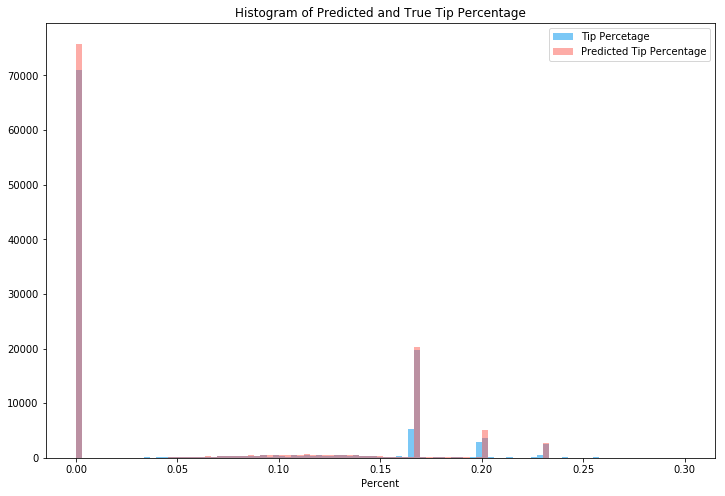

In [22]:
tip_percent_pred = fullmodel(data_test_full_model, data_test_full_model['Tip_percent'])

The tested optimal features for each models are:
    1. Model 1：  'Trip_time', 'Trip_speed', 'Trip_distance', 'Payment_type_1','Payment_type_2', 'Total_amount'.
    2. Model 2:   'Trip_time', 'Trip_speed', 'Total_amount'
    3. Model 2.1: 'Trip_time', 'Trip_speed', 'Total_amount'
    4. Model 2.2: 'Trip_time', 'Trip_rushhours', 'Trip_speed', 'Trip_distance', 'Tolls_amount', 'Total_amount', 'Trip_weekends'
Our full model makes good tip percentage predictions. It captures most of the structure of the histogram of trip percentage. The R square score isn't as high as it supposed to be since we assume that some tip_amount are rounded to their nearest cent, so we treat all tip percentage values falling in range (0.1650, 0.1668) as automatic tip which have chosen 20% button, values in range (0.1950, 0.20075) as 25% button and (0.2270, 0.2310) as 30% button. With this setting, our model ignores rounding variances around the automatic tip choices and captures the main part of this problem. Future research can dig into this rounding issue and build a more complex model to predict them.

## Question 5-Option A

#### 1. Build a derived variable representing the average speed over the course of a trip.
#### 2. Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?

We have built the trip speed variable in the feature engineering step. Now let's have a look at mean trip speed grouped by difference scales.

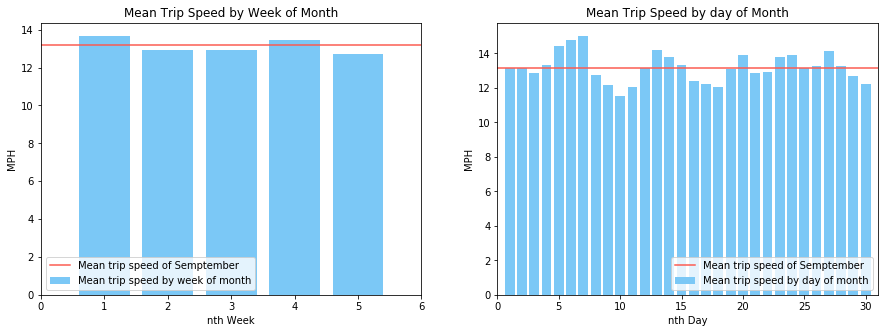

In [23]:
data['Day_of_week'] = (data.Pickup_day % 7 + 1)
# Plotting the mean trip speed by week of month
mean_speed_wom = data.groupby('Trip_week')['Trip_speed'].mean()
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].bar(np.linspace(1,5,5), mean_speed_wom, facecolor='xkcd:lightblue', label="Mean trip speed by week of month")
axs[0].plot(np.linspace(0,6,7), np.ones(7)*data.Trip_speed.mean(), 'xkcd:coral', label = 'Mean trip speed of Semptember')
axs[0].set_title('Mean Trip Speed by Week of Month')
axs[0].set_xlim(0,6)
axs[0].set_xlabel('nth Week')
axs[0].set_ylabel('MPH')
axs[0].legend()
# Plotting the mean trip speed by day of month
mean_speed_dom = data.groupby('Pickup_day')['Trip_speed'].mean()
axs[1].bar(np.linspace(1,30,30), mean_speed_dom, facecolor='xkcd:lightblue', label="Mean trip speed by day of month")
axs[1].plot(np.linspace(-1,32,34), np.ones(34)*data.Trip_speed.mean(), 'xkcd:coral', label = 'Mean trip speed of Semptember')
axs[1].set_title('Mean Trip Speed by day of Month')
axs[1].set_xlim(0,31)
axs[1].set_xlabel('nth Day')
axs[1].set_ylabel('MPH')
axs[1].legend(loc = 4)
plt.show()

The average trip speed for each week in September 2015 doesn't seem very different. They all close to the monthly average (red line) and two of them are above the line and three others are below it. But when we have a look at the mean trip speed for each day of September, we can notice that there are two holes below the monthly average line around Sept.10th and 17th. This may be the reason why the second and third week are below the monthly average line. We need to do some statistical test to support our ideas. Here we use two sample t statistic to test if the average trip speed values are statistically the same.

In [24]:
# Using t statistics to test the null hypothesis that the average trip speed of two weeks are the same.
from scipy.stats import ttest_ind
def test_average_speed(target):
    n = len(target)
    t_stat = np.zeros([n,n])
    p_val  = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if i <= j:
                t_stat[i,j], p_val[i,j] = ttest_ind(target[i], target[j], equal_var=False)
                
    return (t_stat, p_val)    

average_speed_by_week = (data.loc[data.Trip_week==1,'Trip_speed'],
                        data.loc[data.Trip_week==2,'Trip_speed'],
                        data.loc[data.Trip_week==3,'Trip_speed'],
                        data.loc[data.Trip_week==4,'Trip_speed'],
                        data.loc[data.Trip_week==5,'Trip_speed'],)
t_stat, p_val = test_average_speed(average_speed_by_week)
print('Two-Sample t Test:')
print('Null:               average trip speed of week A = average trip speed of week B')
print('Alternative:        average trip speed of week A ≠ average trip speed of week B')
print('P-Value Upper Triangular Matrix:')
print(pd.DataFrame(p_val, columns = ['w1', 'w2','w3','w4','w5',], index = ['w1', 'w2','w3','w4','w5',]))

Two-Sample t Test:
Null:               average trip speed of week A = average trip speed of week B
Alternative:        average trip speed of week A ≠ average trip speed of week B
P-Value Upper Triangular Matrix:
     w1   w2        w3             w4             w5
w1  1.0  0.0  0.000000   5.519246e-32  1.572132e-301
w2  0.0  1.0  0.884254  1.206806e-159   1.300020e-19
w3  0.0  0.0  1.000000  1.231028e-159   3.822043e-20
w4  0.0  0.0  0.000000   1.000000e+00  1.492720e-182
w5  0.0  0.0  0.000000   0.000000e+00   1.000000e+00


According to p-values of the two-sample t test, except week 2 and week 3, all other weeks have p-values less than 0.01 threshold, which means we can reject the null hypothesis and conclude that the average trip speed in those weeks are significantly different with 99% certainty. The p-values between week 2 and week 3 is 0.69, which means we failed to reject the null hypothesis and cannot conclude that whether these two weeks have same average trip speed or not. We can summarize that most weeks have different average trip speed. Why is that?

We introduce some additional data from public reports:
    1. Daily low temperature (℉).
    2. Daily high temperature (℉).
    3. Daily Rainfall (Inch).
    4. Holiday (Labor Day)
Now let's have a look at these new features and how they affect average trip speed.

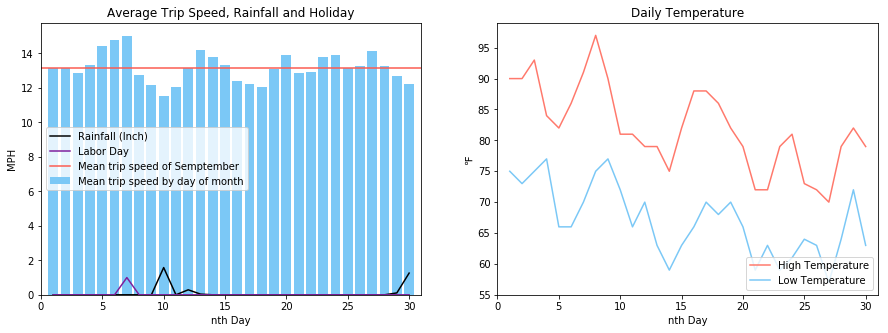

In [25]:
# Adding potential relevant information
low_temp = pd.DataFrame([75,73,75,77,66,66,70,75,77,72,66,70,63,59,63,66,70,68,70,66,59,63,59,61,64,63,57,64,72,63])
high_temp= pd.DataFrame([90,90,93,84,82,86,91,97,90,81,81,79,79,75,82,88,88,86,82,79,72,72,79,81,73,72,70,79,82,79])
rain     = pd.DataFrame([0,0,0,0,0,0,0,0,0,1.58,0,0.29,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.11,1.26])
holidays = pd.DataFrame(np.zeros(30).astype(int))
holidays.iloc[[6],:] = 1
data['Low_temp'] = np.array(low_temp.iloc[data.Pickup_day-1,:])
data['High_temp'] = np.array(high_temp.iloc[data.Pickup_day-1,:])
data['Rainfall'] = np.array(rain.iloc[data.Pickup_day-1,:])
data['Holidays'] = np.array(holidays.iloc[data.Pickup_day-1,:])
# Plotting the average trip speed by day of month and rainfall & holiday
fig, axs = plt.subplots(1, 2, figsize=(15,5))
mean_speed_dom = data.groupby('Pickup_day')['Trip_speed'].mean()
axs[0].bar(np.linspace(1,30,30), mean_speed_dom, facecolor='xkcd:lightblue', label="Mean trip speed by day of month")
axs[0].plot(np.linspace(1,30,30), rain, 'xkcd:black', label="Rainfall (Inch)")
axs[0].plot(np.linspace(1,30,30), holidays, 'xkcd:purple', label="Labor Day")
axs[0].plot(np.linspace(-1,32,34), np.ones(34)*data.Trip_speed.mean(), 'xkcd:coral', label = 'Mean trip speed of Semptember')
axs[0].set_title('Average Trip Speed, Rainfall and Holiday')
axs[0].set_xlim(0,31)
axs[0].set_xlabel('nth Day')
axs[0].set_ylabel('MPH')
axs[0].legend(loc = 6)
# Plotting the daily temperature
axs[1].plot(np.linspace(1,30,30), high_temp, 'xkcd:salmon', label="High Temperature")
axs[1].plot(np.linspace(1,30,30), low_temp, 'xkcd:lightblue', label = 'Low Temperature')
axs[1].set_title('Daily Temperature')
axs[1].set_xlim(0,31)
axs[1].set_xlabel('nth Day')
axs[1].set_ylabel('℉')
axs[1].legend(loc = 4)
plt.show()

We can notice that heavy rain meets average trip speed at its valley and holiday meets at the peak, which means when there is a heavy rain, the average taxi speed is relatively slow and when it is holiday, the average trip speed is fast. According to The Weather Gamut, "September 10th set a new daily rainfall record with 1.58 inches measured in Central Park". This is one of the reasons why taxi speed is so slow on Sept.10th. We didn't find any relationship between temperature and trip speed. But we will further investigate it in the regression step.

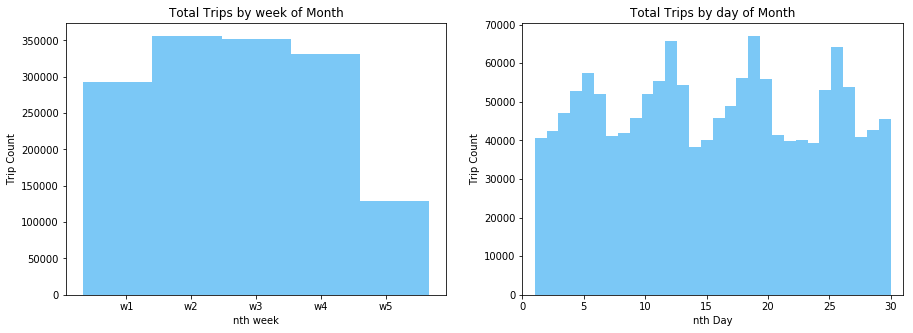

In [26]:
# Plotting the Total Trip Count
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(data.Trip_week, 5, facecolor='xkcd:lightblue', label="Total Trips by day of month")
axs[0].set_title('Total Trips by week of Month')
axs[0].set_xticks([1.5,2.25,3,3.75,4.5])
axs[0].set_xticklabels(['w1','w2','w3','w4','w5'])
axs[0].set_xlabel('nth week')
axs[0].set_ylabel('Trip Count')
# Plotting the daily temperature
axs[1].hist(data.Pickup_day, 30, facecolor='xkcd:lightblue', label="Total Trips by week of month")
axs[1].set_title('Total Trips by day of Month')
axs[1].set_xlim(0,31)
axs[1].set_xlabel('nth Day')
axs[1].set_ylabel('Trip Count')
plt.show()

These two total trip plots show that total taxi trips are relatively larger in the second and third week of September 2015. According to NYC event bulletin websites, there were several big events took place in these two weeks. They include: 1. 911 14th year memorial event; 2. New York City Broadway Week (Sept.5th - Sept.20th); 3. Madonna's concert (Sept.16th) and etc. There might be many more events in September had attracted a lot of tourist. Busy traffic in these two weeks explains the slow average trip speed. Therefore, my hypothesis is: the average trip speed can be influenced by heavy rain, large tourist volume and rebound effect after holidays. There are many other effects have different impact on average trip speed. we will talk about it in next section.

#### 3. Can you build up a hypothesis of average trip speed as a function of time of day?

Let's have a look at the average trip speed grouped by day of week and hour of day:

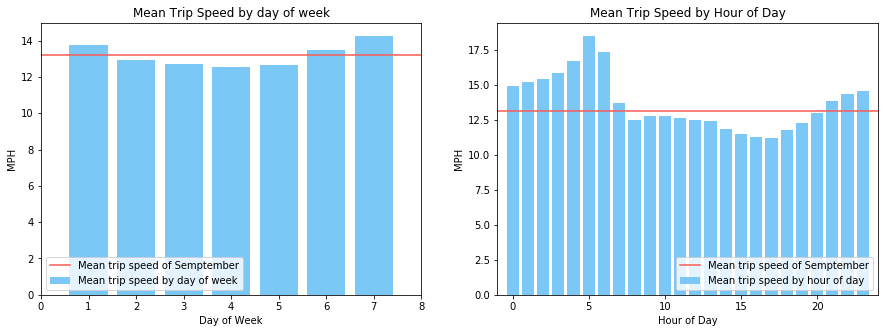

In [27]:
# Plotting the mean trip speed by day of week
mean_speed_dow = data.groupby('Day_of_week')['Trip_speed'].mean()
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].bar(np.linspace(1,7,7), mean_speed_dow, facecolor='xkcd:lightblue', label="Mean trip speed by day of week")
axs[0].plot(np.linspace(0,8,9), np.ones(9)*data.Trip_speed.mean(), 'xkcd:coral', label = 'Mean trip speed of Semptember')
axs[0].set_title('Mean Trip Speed by day of week')
axs[0].set_xlim(0,8)
axs[0].set_xlabel('Day of Week')
axs[0].set_ylabel('MPH')
axs[0].legend()
# Plotting the mean trip speed by hour of day
mean_speed_hod = data.groupby('Hour_of_day')['Trip_speed'].mean()
axs[1].bar(np.linspace(0,23,24), mean_speed_hod, facecolor='xkcd:lightblue', label="Mean trip speed by hour of day")
axs[1].plot(np.linspace(-1,24,26), np.ones(26)*data.Trip_speed.mean(), 'xkcd:coral', label = 'Mean trip speed of Semptember')
axs[1].set_title('Mean Trip Speed by Hour of Day')
axs[1].set_xlim(-1,24)
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('MPH')
axs[1].legend(loc = 4)
plt.show()

The first bar plot shows the average trip speed grouped by day of week. We can see that the trips in weekends tend to have average speed higher than the monthly average. The weekdays tend to be lower than monthly average. The right figure shows that taxis drive faster in the mornings (around 5:00), and drive slower in the evenings (around 17:00). The relationship between hour of day and average trip speed is obviously not linear. We can build a polynomial function or other non-linear models to fit this curve, but doing that will make it difficult to explain the real meaning of the relationship. So, I construct another time variable: Away From Morning. It is the shortest time period between now and either last or next 5:00. It can be computed using this formula {min(abs(now-5:00), abs(now-29:00))}. This variable will help us explain the relationship between time and trip speed. Let's put it with average trip speed in one figure:

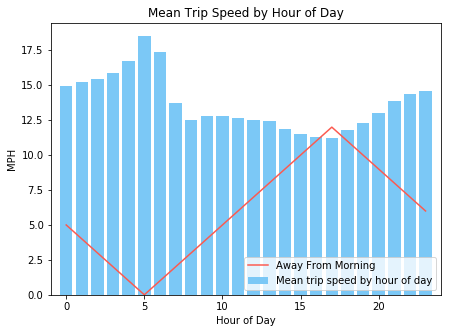

In [28]:
data['Away_from_morning'] = np.amin([abs(data.Hour_of_day-5),abs(data.Hour_of_day-29)],axis=0)
fig, axs = plt.subplots(figsize=(7,5))
mean_speed_hod = data.groupby('Hour_of_day')['Trip_speed'].mean()
away_from_morning = np.amin([abs(np.arange(24)-5),abs(np.arange(24)-29)],axis=0)
axs.bar(np.linspace(0,23,24), mean_speed_hod, facecolor='xkcd:lightblue', label="Mean trip speed by hour of day")
axs.plot(np.linspace(0,23,24), np.array(away_from_morning), 'xkcd:coral', label = 'Away From Morning')
axs.set_title('Mean Trip Speed by Hour of Day')
axs.set_xlim(-1,24)
axs.set_xlabel('Hour of Day')
axs.set_ylabel('MPH')
axs.legend(loc = 4)
plt.show()

Visually, we can find strong negative correlation between Away From Morning variable and average trip speed. We can use this variable and many other variables to build a regression model and use backward elimination method to exclude less relevant variables. The optimal model is shown below:

In [29]:
# Build model; trip_speed = alpha + beta * X + ep
import statsmodels.formula.api as sm
OLS_regressor2 = sm.OLS(data.Trip_speed,data[['Trip_distance',
                                            'Trip_airport',  'VendorID_1',  
                                            'Trip_type_1', 'Trip_manhattan',
                                            'Trip_time', 'Trip_weekends', 'Holidays',
                                            'Low_temp', 'High_temp', 'Rainfall',
                                            'Away_from_morning']]).fit()
OLS_regressor2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Trip_speed   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                 4.809e+05
Date:                Wed, 20 Feb 2019   Prob (F-statistic):               0.00
Time:                        07:42:03   Log-Likelihood:            -4.8843e+06
No. Observations:             1461847   AIC:                         9.769e+06
Df Residuals:                 1461835   BIC:                         9.769e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Trip_distance         1.0527      0.002    475.186      0.000       1.048       1.057
Trip_airport          4.0886      0.047     86.782      0.000       3.996       4.181
VendorID_1            0.1426      0.014     10.383      0.000       0.116       0.170
Trip_type_1          -0.1274      0.041     -3.090      0.002      -0.208      -0.047
Trip_manhattan       -0.3891      0.016    -24.398      0.000      -0.420      -0.358
Trip_time             0.0097      0.000     24.847      0.000       0.009       0.010
Trip_weekends         1.3533      0.013    107.810      0.000       1.329       1.378
Holidays              0.8166      0.035     23.112      0.000       0.747       0.886
Low_temp              0.0113      0.002      6.954      0.000       0.008       0.014
High_temp             0.1312      0.001     96.964      0.000       0.129       0.134
Rainfall             -0.2838      0.016    -17.269      0.000      -0.316      -0.252
Away_from_morning    -0.2608      0.002   -146.328      0.000      -0.264      -0.257
==============================================================================
Omnibus:                  2454528.227   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3518290543.897
Skew:                          11.319   Prob(JB):                         0.00
Kurtosis:                     242.268   Cond. No.                         888.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this multiple linear regression model, every estimated coefficients are significantly non-zero at 99% confident level. There is no multi-colinearity problem and the adjusted R square value is 0.798, which means this model explained 79.8% of total variance within the average trip speed data. Let's discuss the implications of these coefficients one by one：
    1. For a long-distance trip, the taxi drivers tend to drive faster. The airport trips are on average 4.08 mph faster than non-airport trips. This can be explained by long distance, and less traffic near the airports.
    2. For taxis using Creative Mobile Technologies' meters, the average trip speed is 0.14 mph faster than those using VeriFone Inc's.
    3. Street-hail trips are 0.13 mph slower than dispatch trips. It may because of relatively short distance and heavy downtown traffic.
    4. Manhattan trips tend to be slower due to the heavy traffic.
    5. Trips in weekends or on holidays tend to be faster since people travel further if they don't go to work. In addition, in weekdays, the city is fully functional hence more active traffic.
    6. When temperature is higher, the average trip speed is faster.
    7. Rainfall significantly decreases traffic speed.
    8. Every hour away from morning 5 AM, the taxis are 0.26 mph slower in average speed.